# Project goal

Here we have the goals on the covid-19 worldwide analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths and confirmed cases);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a country);</li>
</ul>

# Init process: import libraries, load datasets and evaluate data for next the phases

Import ncessary libraries.

In [1]:
import pandas as pd
from pandas import DataFrame
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import copy
import os
import math
from os import listdir
from datetime import date,timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.metrics import max_error
from sklearn.cluster import KMeans

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import decomposition, datasets

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

from pyramid.arima import auto_arima

%matplotlib inline
%run Utilities.ipynb
warnings.filterwarnings("ignore")


C:\Users\pro48\AppData\Local\Continuum\anaconda3\envs\covid19\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\pro48\AppData\Local\Continuum\anaconda3\envs\covid19\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\pro48\AppData\Local\Continuum\anaconda3\envs\covid19\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package

Set the date to consider as the last date. In this way, because data are dayly updated, it is possible to freeze our analysis to a specific date.

In [2]:
LAST_DATE_TO_CONSIDER = '2020-05-20'


Load dataset about total deaths, new deaths, total cases and new cases.

In [3]:
#load full dataset of coronavirus from internet
df_all_data__ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#rename columns with more meaningful name
df_all_data__.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_all_data__.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths
21700,2020-06-01,Zimbabwe,4,0,178,4
21701,2020-06-02,Zimbabwe,25,0,203,4
21702,2020-06-03,Zimbabwe,3,0,206,4
21703,2020-06-04,Zimbabwe,16,0,222,4
21704,2020-06-05,Zimbabwe,15,0,237,4


Remove data after the last date to consider.

In [4]:
df_all_data__=df_all_data__[df_all_data__['Date']<= LAST_DATE_TO_CONSIDER]
df_all_data__=df_all_data__.reset_index()
df_all_data__.tail()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths
18341,21684,2020-05-16,Zimbabwe,5,0,42,4
18342,21685,2020-05-17,Zimbabwe,2,0,44,4
18343,21686,2020-05-18,Zimbabwe,2,0,46,4
18344,21687,2020-05-19,Zimbabwe,0,0,46,4
18345,21688,2020-05-20,Zimbabwe,0,0,46,4


Load population dataset. The dataset is updated with 2020 data. 
It has been downloaded from:
https://www.kaggle.com/tanuprabhu/population-by-country-2020.

It is currently saved locally.
The dataset contains for each country the number of inhabitants. This dataset is used later to plot covid-19 deaths and cases basing on number of inhabitants.

In [5]:
#load population dataset keeping only the necessary columns 
#(countries and number of inhabitants) renaiming them
df_population = pd.read_csv("../COVID19_analysis/dataset/population_by_country_2020.csv")
df_population = df_population[['Country (or dependency)','Population (2020)']]
df_population.drop_duplicates(inplace = True)
df_population.rename(columns={"Country (or dependency)": "Country",
                            "Population (2020)":"Population"}, inplace = True)
df_population.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


Load lockdown dataset. The dataset has been downloaded from:
https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country#countryLockdowndates.csv.

It is currently saved locally.
It contains the following columns:
<ul>
<li>country</li>
<li>province of the country</li>
<li>date in which the lockdown has been put in place</li>
<li>type of lockdown (full, partial or none)</li>
<li>reference (source of the data).</li>
</ul>

In [6]:
#load lockdown dataset
df_lockdown = pd.read_csv("../COVID19_analysis/dataset/countryLockdowndates.csv")

#rename column relative to country
df_lockdown.rename(columns={"Country/Region": "Country","Date":"Beginning Date"}, inplace = True)
#convert string date format from 'dd/mm/yyyy' to 'yyyy-mm-dd'
df_lockdown['Beginning Date'] = pd.to_datetime(df_lockdown['Beginning Date'])
#rename country value from 'US' to 'United States' where needed
df_lockdown['Country'] = df_lockdown['Country'].apply(lambda x : 'United States' if x == 'US' else x)
#delete 'Reference column'
df_lockdown.drop('Reference', axis = 1, inplace = True)
#if value in 'Province' column is not present, 
#replace it with value in 'Country' column
df_lockdown.Province.fillna(df_lockdown.Country, inplace = True)
#keep only the country where the value in the Country column is equal 
#to the value in the Province column. In this way, it eliminates the
#rows reguarding colonies
df_lockdown = df_lockdown[df_lockdown.Province == df_lockdown.Country]
#drop the Province column because it is not necessary
df_lockdown.drop('Province', axis = 1, inplace = True)
df_lockdown.head()

,Country,Beginning Date,Type
0,Afghanistan,2020-03-24,Full
1,Albania,2020-03-08,Full
2,Algeria,2020-03-24,Full
3,Andorra,2020-03-16,Full
4,Angola,2020-03-24,Full


Load population density dataset. The dataset is downloaded from:
https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv

In [7]:
#load dataset
pd.set_option('mode.chained_assignment', None)
df_population_density_ = pd.read_csv("../COVID19_analysis/dataset/population_density.csv")
df_population_density = df_population_density_[['Country','Pop. Density (per sq. mi.)']]
df_population_density.rename(columns = {'Pop. Density (per sq. mi.)': 'Population density'}, inplace = True)
#trim country value because original dataset has a space at the end
df_population_density['Country'] = df_population_density['Country'].apply(lambda x : x.strip())
df_population_density.head()

,Country,Population density
0,Afghanistan,48.0
1,Albania,124.6
2,Algeria,13.8
3,American Samoa,290.4
4,Andorra,152.1


Merge coronavirus dataset and population dataset.

In [8]:
df_all_data_ =df_all_data__.copy()
df_all_data_ = pd.merge (left = df_all_data_, right = df_population, on = 'Country')
df_all_data_ = pd.merge (left = df_all_data_, right = df_population_density, on = 'Country')
df_all_data_['Date'] = pd.to_datetime(df_all_data_['Date'])
df_all_data_.head()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density
0,0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0
1,1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0
2,2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0
3,3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0
4,4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0


Evaluate number of cases and deaths per million of inhabitants and store the information in new columns of the full dataset.

In [9]:
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New cases',
                                            'New cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total cases',
                                            'Total cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New deaths',
                                            'New deaths per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total deaths',
                                            'Total deaths per million of inhabitants')
df_all_data_.tail()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants
15787,21684,2020-05-16,Zimbabwe,5,0,42,4,14862924,31.3,0.336408,2.825824,0.0,0.269126
15788,21685,2020-05-17,Zimbabwe,2,0,44,4,14862924,31.3,0.134563,2.960387,0.0,0.269126
15789,21686,2020-05-18,Zimbabwe,2,0,46,4,14862924,31.3,0.134563,3.094950,0.0,0.269126
15790,21687,2020-05-19,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126
15791,21688,2020-05-20,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126


Add lockdown information in the full dataset. For each row, create a new column where if in the country for that date was not present the lockdown, the value is set to 0, if the lockdown is partial set a value of 1, if the lockdown is full, set the value to 2. 

In [10]:
#make a copy of the full dataset
#merge lockdown dataset with full dataset
df_all_data = df_all_data_.copy()
df_all_data = df_all_data.merge(df_lockdown, on='Country', how='left')

#create a new column setting an initial default value of -1.
#This value has no meaning. Its only a "jolly" value that evidences
#that the value hano not been set yet
df_all_data['Lockdown state'] = -1

#set a correct value for each row in the full dataset that depends
#on the lockdown type in that particula date for each country
for i in range(len(df_all_data)):
    if(df_all_data.iloc[i]['Type'] == 'None'):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    elif(df_all_data.iloc[i]['Date'] < df_all_data.iloc[i]['Beginning Date']):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    else:
        if(df_all_data.iloc[i]['Type'] == 'Full'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 2
        elif(df_all_data.iloc[i]['Type'] == 'Partial'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 1
        else:
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = -2

#drop Type column because it is not usefull now
del df_all_data['Type']

df_all_data.head()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state
0,0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
1,1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
2,2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
3,3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
4,4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0


Associate a color to each country that will be used later when plotting the data. In this way, the same country will be showed in different graphs with the same color.

In [11]:
colorMap(df_all_data.Country.unique(),0)

# Data visualization

## Analysis by country on the total number of deaths and cases without considering the number of inhabitants 

Firstly, it would be interesting to compare the growth about the number of deaths and cases of some countries starting from a specific point, meant as a common starting point, for a better comparison. Next steps are used to estabilish which is the starting point.

In the first step it is necessary to retrieve what the top ten countries for number of deaths are.

In [12]:
#create a copy of the dataset keeping the necessary columns
df_total_deaths = df_all_data[['Country','Total deaths']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_deaths = df_group_total_deaths.iloc[0:10]
top_10_total_deaths.reset_index(inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths['Total deaths'].sum(), end ="\n\n")
top_10_total_deaths

World number of deaths: 322084



,Country,Total deaths
0,United States,91921
1,United Kingdom,35341
2,Italy,32169
3,France,28022
4,Spain,27888
5,Brazil,17971
6,Belgium,9108
7,Germany,8090
8,Iran,7119
9,Canada,5912


Plot the total number of deaths, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

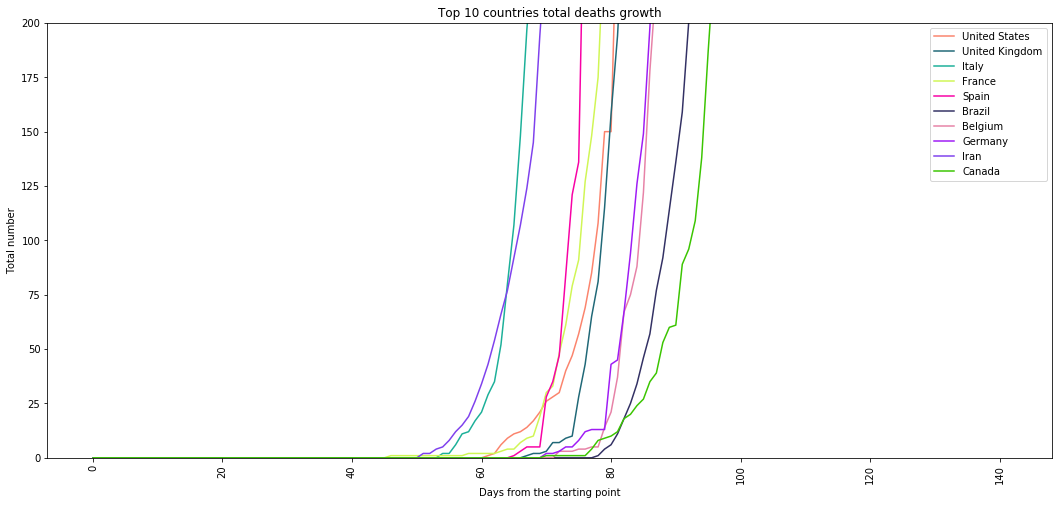

<Figure size 1080x540 with 0 Axes>

In [108]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth',
                            0, 200)

It is possible to set the starting point to 50 deaths, and this will be the common starting point for comparing the data.

Print data of the top 10 countries for number of deaths and plot the growth starting from the first 50 confirmed deaths.

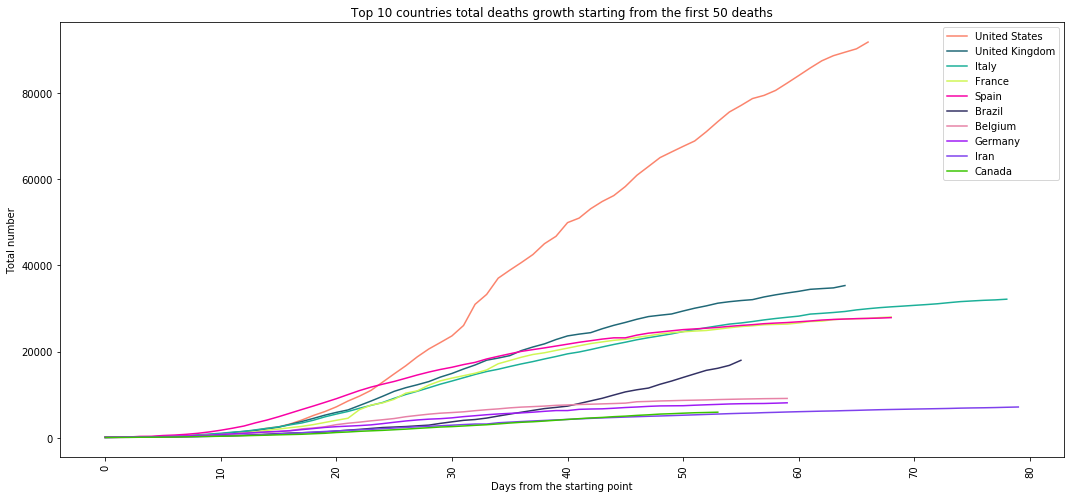

<Figure size 1080x540 with 0 Axes>

In [109]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            50)

It is intersting to see how the grow in United States is faster than in the other countries. Now, let's plot the data with a logarithmic scale to better view the other countries. The starting point is set to 1.69, that correspond to 50 deaths in the normal scale

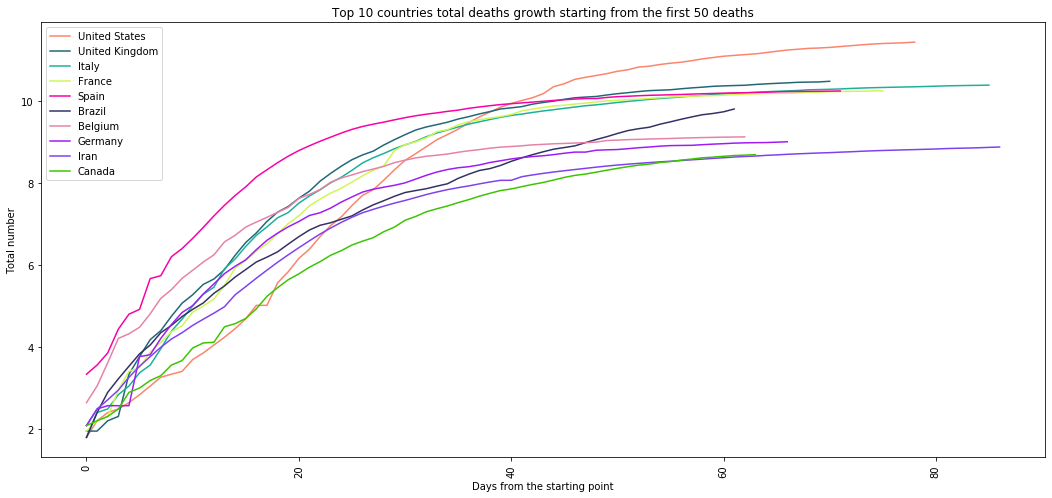

<Figure size 1080x540 with 0 Axes>

In [110]:
df_total_deaths_log = df_total_deaths.copy()
df_total_deaths_log['Total deaths'] = df_total_deaths_log['Total deaths'].replace(0, 1)
df_total_deaths_log['Total deaths'] = np.log(df_total_deaths_log['Total deaths'])
df_total_deaths_log

#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_log, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            1.69)

Also with a logarithmic scale the visualization is a bit confusing.

So, back to the normal scale but reducing the number of countries. Let's set it to 5.

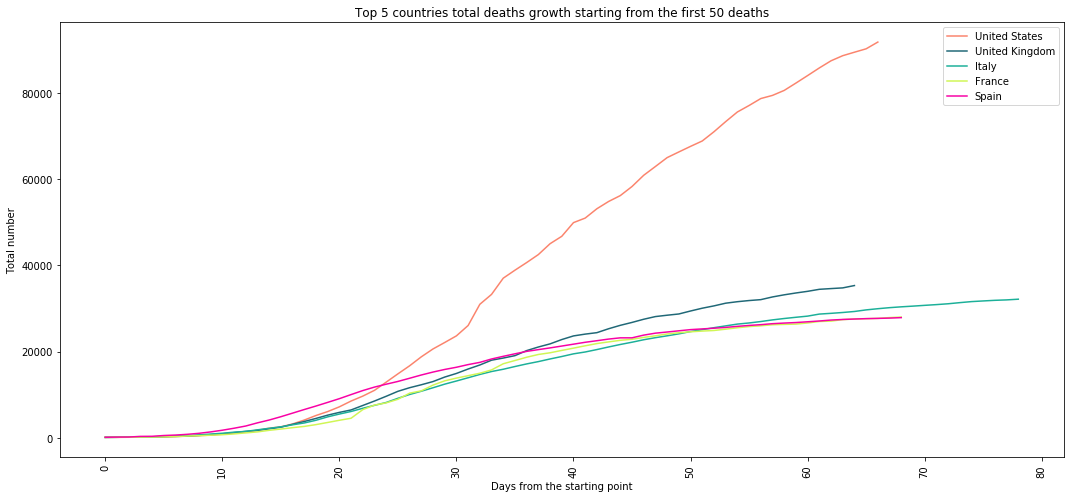

<Figure size 1080x540 with 0 Axes>

In [111]:
#loc the first 5 rows
top_5_total_deaths = df_group_total_deaths.iloc[0:5]
top_5_total_deaths.reset_index(inplace = True)
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_5_total_deaths['Country'], 'Total deaths',
                            'Top 5 countries total deaths growth starting from the first 50 deaths',
                            50)

The same procedure is used for confirmed cases.
First, retrieve information about top 10 countries for total number of cases.

In [17]:
#create a copy of the dataset keeping the necessary columns
df_total_cases = df_all_data[['Country','Total cases']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases = df_group_total_cases.iloc[0:10]
top_10_total_cases.reset_index(inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases['Total cases'].sum(), end ="\n\n")
top_10_total_cases

World number of cases: 4828410



,Country,Total cases
0,United States,1528568
1,Russia,299941
2,Brazil,271628
3,United Kingdom,248818
4,Spain,232555
5,Italy,226699
6,Germany,176007
7,Turkey,151615
8,France,143427
9,Iran,124603


Plot the total number of cases, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

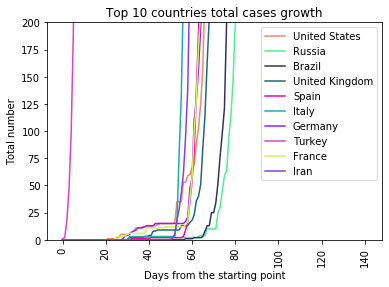

<Figure size 1080x540 with 0 Axes>

In [18]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'], 'Total cases',
                            'Top 10 countries total cases growth',
                            0, 200)

Because of a stabilization period in many countries around about 25 cases, this time, the starting point is set to 25 cases.

Print data of the top 10 countries for number of cases and plot the growth starting from the first 25 confirmed case.

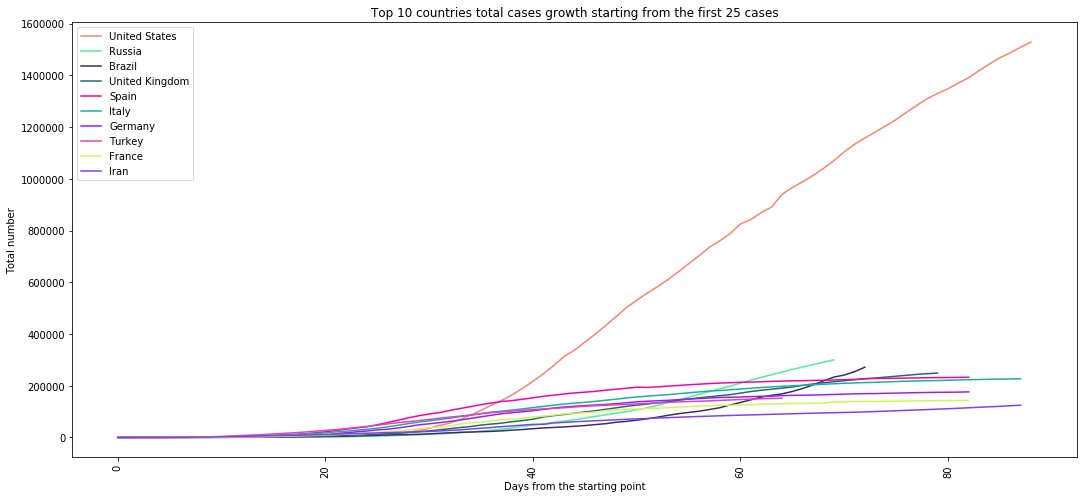

<Figure size 1080x540 with 0 Axes>

In [112]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first 25 cases',
                            25)

Also in this case, because the top 10 cases visualization is a bit confusing, let's focus on the top 5.

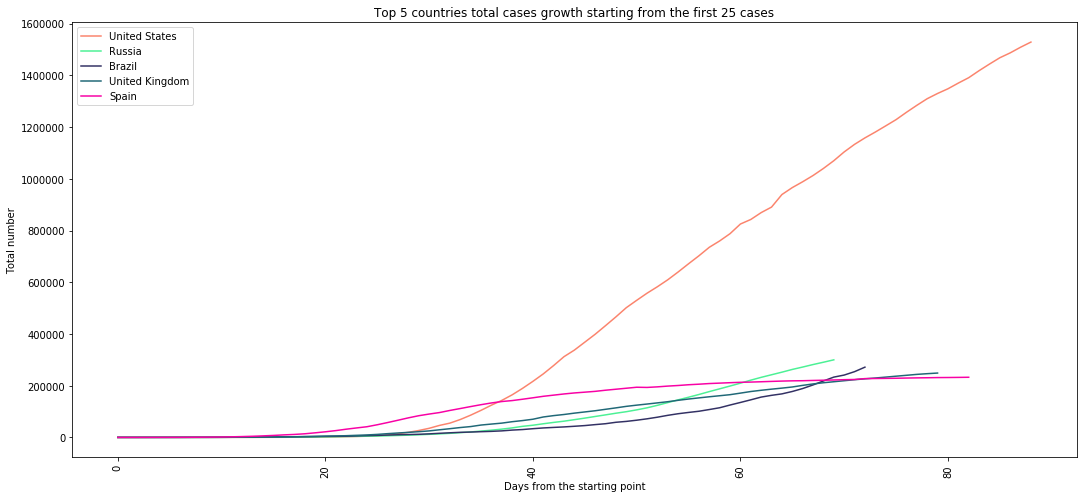

<Figure size 1080x540 with 0 Axes>

In [113]:
#loc the first 5 rows
top_5_total_cases = df_group_total_cases.iloc[0:5]
top_5_total_cases.reset_index(inplace = True)
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_5_total_cases['Country'], 'Total cases',
                            'Top 5 countries total cases growth starting from the first 25 cases',
                            25)

As it is quite obvious, countries in the top list for number of deaths are present also in the top list for number of cases.

## Analysis by country on the total number of deaths and cases considering the number of inhabitants

As done before, firstly, print data of top ten countries for total deaths.

In [21]:
#create a copy of the dataset
df_total_deaths_x_million = df_all_data[['Country',
                                         'Total deaths per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total deaths per million of inhabitants',ascending = False, inplace = True)


#loc the first 10 rows
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[0:10]
top_10_total_deaths_x_million.reset_index(inplace = True)
top_10_total_deaths_x_million

,Country,Total deaths per million of inhabitants
0,San Marino,1208.334561
1,Belgium,785.875434
2,Andorra,660.066007
3,Spain,596.473798
4,Italy,532.054722
5,United Kingdom,520.593263
6,France,429.301252
7,Sweden,370.621030
8,Netherlands,333.530358
9,Ireland,316.133587


Plot data day by day of the top 10 countries to try to detect a common starting point for comparing the growth focusing on a range between 0 and 20 cases per million of inhabitants.

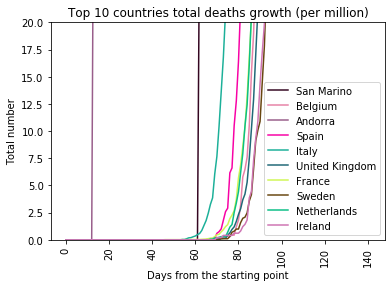

<Figure size 1080x540 with 0 Axes>

In [22]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth (per million)',
                            0, 20)

For some countries, such as Andorra and San Marino, there is not a slow growth but they have a very fast increase. A part these, it is possible to consider, as a common starting point, a value of 2.5.

Plot the growth starting from the point where the rate was upper than 2.5.

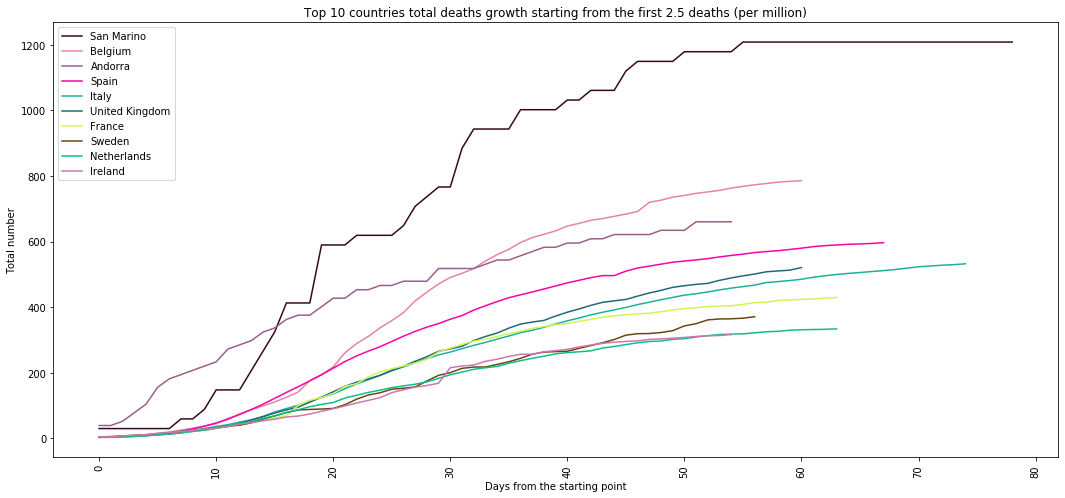

<Figure size 1080x540 with 0 Axes>

In [114]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth starting from the first 2.5 deaths (per million)',
                            2.5)

The growth is almost linear for the top 10 countries.

Print data of the top 10 countries for number of cases per million.

In [24]:
#create a copy of the dataset
df_total_cases_x_million = df_all_data[['Country',
                                         'Total cases per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total cases per million of inhabitants',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[0:10]
top_10_total_cases_x_million.reset_index(inplace = True)
top_10_total_cases_x_million

,Country,Total cases per million of inhabitants
0,San Marino,19303.881406
1,Qatar,12358.675804
2,Andorra,9849.220216
3,Luxembourg,6322.905917
4,Iceland,5280.694403
5,Spain,4973.930151
6,Singapore,4921.763548
7,Ireland,4911.310454
8,Belgium,4813.875309
9,United States,4617.993226


As done before, plot the growth to detect a common comparison starting point focusing on a range between 0 and 20 cases per million of inhabitants.

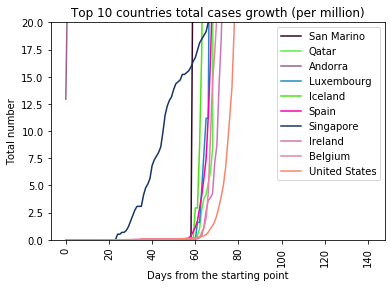

<Figure size 1080x540 with 0 Axes>

In [25]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth (per million)',
                            0, 20)

The growth increases very fast. A common starting point for comparison could be 2.5 cases per million of inhabitants.

Plot the growth starting from the point where the rate was upper than 2.5 cases per million of inhabitants.

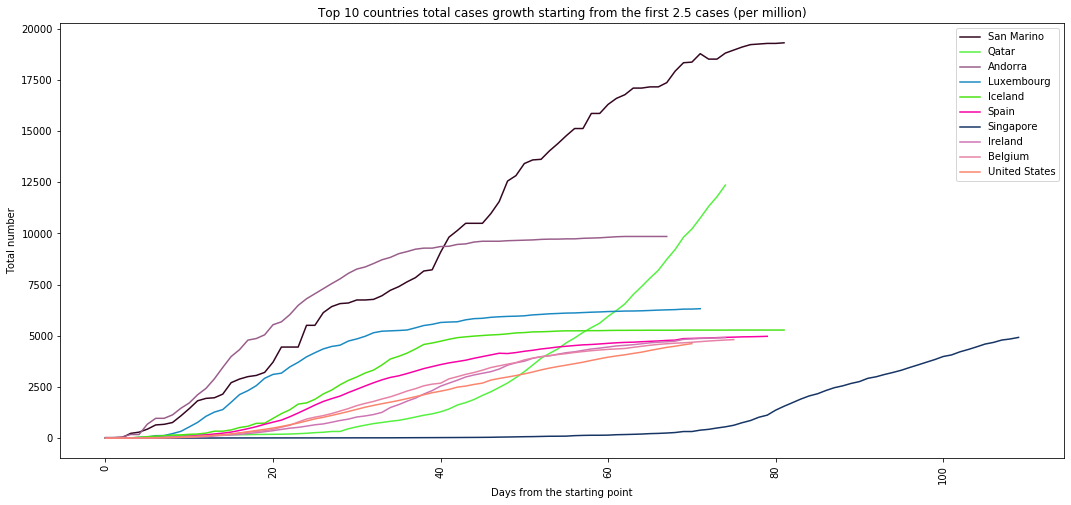

<Figure size 1080x540 with 0 Axes>

In [115]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth starting from the first 2.5 cases (per million)',
                            2.5)

It is interesting to see how small countries have a higher concentration of deaths and cases and they occupies the first places in number of cases and deaths in this ranking. It is now possible to find out if there is a correlation between population density and the virus spread. Following, the population density distribution. 

## Analysis  by country on the new deaths and new cases

Print data of the top ten day/country for new deaths

In [27]:
#copy the dataframe
df_new_deaths = df_all_data[['Date','Country','New deaths']].copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
15229,2020-04-16,United States,4928
15231,2020-04-18,United States,3770
15237,2020-04-24,United States,3179
15243,2020-04-30,United States,2611
15235,2020-04-22,United States,2524
15228,2020-04-15,United States,2408
15250,2020-05-07,United States,2353
15230,2020-04-17,United States,2299
15251,2020-05-08,United States,2239
15239,2020-04-26,United States,2172


Print data of the top ten day/country for new cases

In [28]:
#copy the dataframe
df_new_cases = df_all_data[['Date','Country','New cases']].copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
15239,2020-04-26,United States,48529
15235,2020-04-22,United States,37289
15224,2020-04-11,United States,35527
15218,2020-04-05,United States,34272
15245,2020-05-02,United States,33955
15223,2020-04-10,United States,33901
15222,2020-04-09,United States,33323
15232,2020-04-19,United States,32922
15217,2020-04-04,United States,32425
15230,2020-04-17,United States,31667


United states has the top ten new cases in different days of both the ranking.

Evaluate the moving average for new deaths and new cases taking in consideration a period of 10 days. This dataset will be used later for further analysis.

In [29]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new deaths for the row date
df_matrix_new_deaths = get_matrix_dataset(df_, 'New deaths')
df_matrix_new_deaths.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-16,32,0,7,0,0,0,3,3,0,0,...,384,1662,0,0,0,0,0,2,0,0
2020-05-17,0,0,6,2,0,0,7,3,0,0,...,468,1186,0,0,0,0,0,4,0,0
2020-05-18,1,0,6,0,0,0,3,5,0,0,...,170,808,1,1,0,0,0,1,0,0
2020-05-19,4,0,7,0,0,0,16,1,0,1,...,160,791,0,1,0,0,0,0,0,0
2020-05-20,5,0,6,0,0,0,11,3,0,0,...,545,1568,0,0,0,0,0,8,0,0


In [30]:
#evaluate the moving average of the new deaths matrix
df_new_deaths_moving_average_ = df_matrix_new_deaths.copy()
df_new_deaths_moving_average = evaluate_moving_average(df_new_deaths_moving_average_, 10)
df_new_deaths_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-16,4,0,5,0,0,0,9,1,0,1,...,594,1791,0,0,0,0,0,0,0,0
2020-05-17,4,0,5,0,0,0,7,1,0,1,...,579,1788,0,0,0,0,0,0,0,0
2020-05-18,4,0,5,0,0,0,8,1,0,1,...,602,1855,0,0,0,0,0,0,0,0
2020-05-19,4,0,5,0,0,0,8,1,0,1,...,622,1942,0,0,0,0,0,0,0,0
2020-05-20,4,0,5,0,0,0,8,1,0,0,...,593,1882,0,0,0,0,0,0,0,0


In [31]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new cases for the row date
df_matrix_new_cases = get_matrix_dataset(df_, 'New cases')
df_matrix_new_cases.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-16,1063,18,187,0,0,0,345,184,0,30,...,3560,25508,8,46,4,1,0,19,14,5
2020-05-17,0,17,192,0,0,0,326,239,0,17,...,3450,24487,1,50,45,5,0,18,11,2
2020-05-18,262,13,198,0,0,0,0,189,0,9,...,3534,18873,1,12,37,2,0,4,74,2
2020-05-19,408,2,182,0,0,0,566,351,0,15,...,2711,21841,3,49,77,4,0,2,8,0
2020-05-20,581,1,176,0,2,0,438,218,0,8,...,2412,19970,1,78,131,0,0,37,11,0


In [32]:
#evaluate the moving average of the new cases matrix
df_new_cases_moving_average_ = df_matrix_new_cases.copy()
df_new_cases_moving_average = evaluate_moving_average(df_new_cases_moving_average_, 20)
df_new_cases_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-16,54,17,93,13,0,0,98,45,1,50,...,5078,28914,8,78,8,1,0,0,2,1
2020-05-17,58,17,96,11,0,0,110,46,1,47,...,5028,30070,9,76,8,1,0,0,2,1
2020-05-18,59,17,97,10,0,0,106,48,1,43,...,5061,29885,9,74,8,0,0,0,2,1
2020-05-19,66,17,102,9,0,0,113,50,1,38,...,5095,29482,10,70,8,0,0,0,2,1
2020-05-20,70,17,103,8,0,0,115,52,1,34,...,5020,29022,9,69,8,0,0,0,2,1


## Analysis of the percentage of growth

In this section, an evaluation on the growth rate for the total number of deaths and cases has been computed. The growth rate is evaluated weekly. Then the top 5 countries data are displayed.

Create a dataframe with the weekly total deaths grow rate for each country.

In [33]:
df_total_deaths = df_all_data[['Date','Country','Total deaths']].copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 7, 'Total deaths')

Plot the death grow rate of the top 5 countries for deaths.

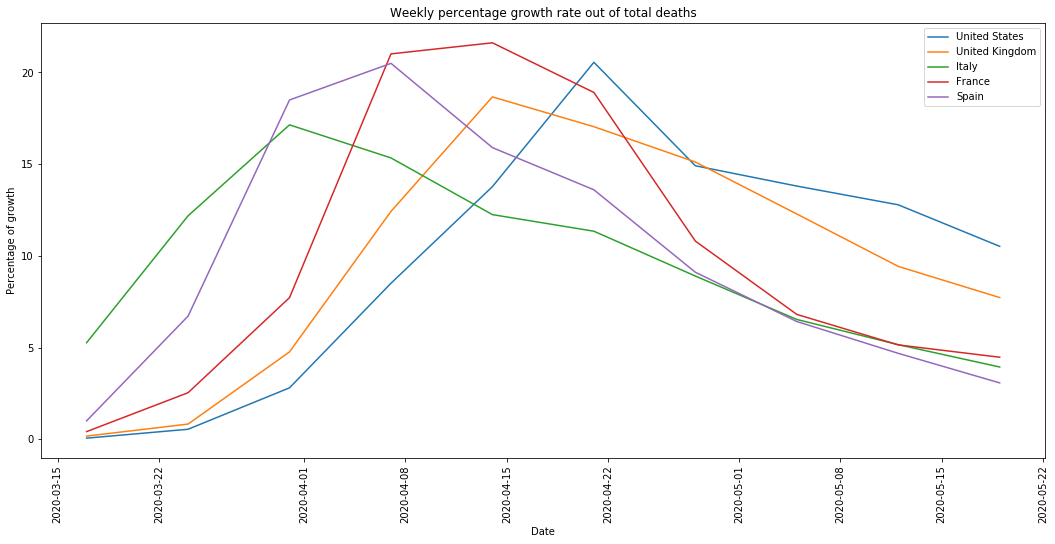

In [116]:
#get the list of the top 5 countries
top_5_death_countries_list = top_10_total_deaths['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_deaths_growth = death_growth_rate[top_5_death_countries_list]

some_countries_deaths_growth=some_countries_deaths_growth[some_countries_deaths_growth>0]
some_countries_deaths_growth=some_countries_deaths_growth.dropna()
for country in top_5_death_countries_list:
    plt.plot(some_countries_deaths_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Weekly percentage growth rate out of total deaths")
plt.xlabel("Date")
plt.ylabel("Percentage of growth")
plt.show()

Create a dataframe with the weekly total cases grow rate for each country.

In [35]:
df_total_cases = df_all_data[['Date','Country','Total cases']].copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 7, 'Total cases')

Plot the grow rate of the top 5 countries for number of cases.

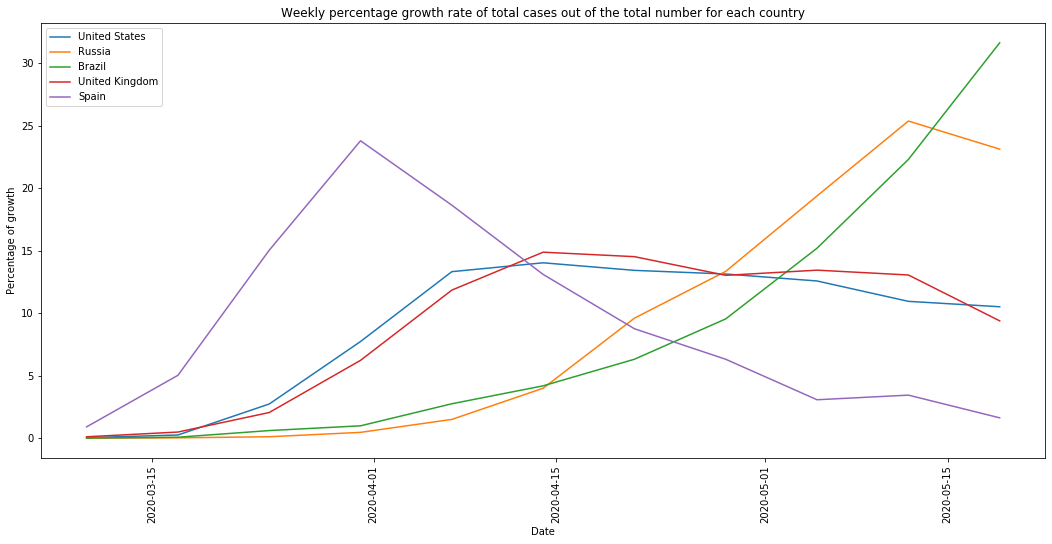

In [117]:
#get the list of the top 5 countries
top_5_case_countries_list = top_10_total_cases['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_cases_growth = case_growth_rate[top_5_case_countries_list]
some_countries_cases_growth=some_countries_cases_growth[some_countries_cases_growth > 0]
some_countries_cases_growth=some_countries_cases_growth.dropna()
for country in top_5_case_countries_list:
    plt.plot(some_countries_cases_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Weekly percentage growth rate of total cases out of the total number for each country")
plt.xlabel("Date")
plt.ylabel("Percentage of growth")
plt.show()

While for the total deaths growth rate the trend in the top 5 countries is similar, with a peak between 15 times and 20 times in a week, the growth rate in the total cases is quite different. Only United Kingdom and United States have a similar trend. Brazil growth rate is very worrying and it has a similar trend of Russia. But for Russia the trend seems to reach the peak and in the last week the value is decreasing. One more consideration is that Spain has growth very fast but also very fast has slow down while United Kingdom and United States the trend is stationary on about 15 times per week.

# Correlation between virus spread and population density

First of all, let's see the distribution of the population density

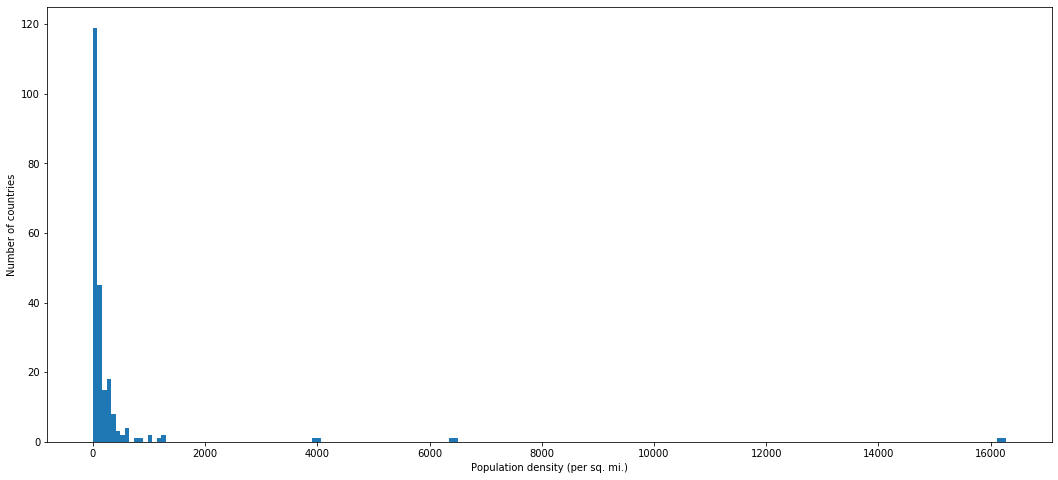

In [127]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.xlabel("Population density (per sq. mi.)")
plt.ylabel("Number of countries")
plt.show()

To better visualize the distribution, a cut is placed at 1500 in the plot visualization. There are a few values upper than that. 

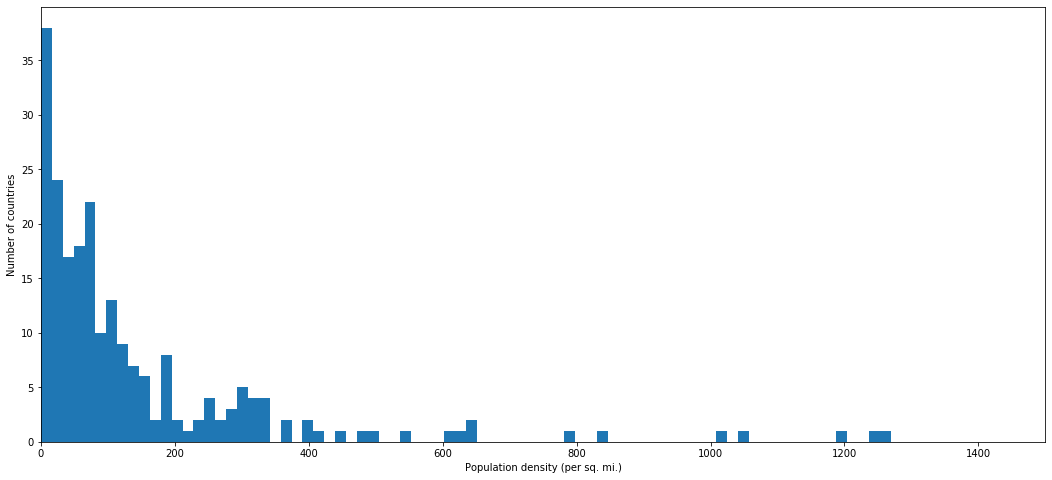

In [126]:
#plot population density
plt.hist(df_population_density['Population density'], bins=1000) 
plt.xlim(0, 1500)
plt.xlabel("Population density (per sq. mi.)")
plt.ylabel("Number of countries")
plt.show()

Print also some statistical information of these data.

In [39]:
df_population_density['Population density'].describe()

count      227.000000
mean       379.047137
std       1660.185825
min          0.000000
25%         29.150000
50%         78.800000
75%        190.150000
max      16271.500000
Name: Population density, dtype: float64

Now, let's plot the top 10 countries for population density

In [40]:
df_population_density_ = df_population_density.copy()
df_population_density_.sort_values(by = 'Population density',ascending = False, inplace = True)
df_population_density_.head(10)

,Country,Population density
138,Monaco,16271.5
122,Macau,16183.0
184,Singapore,6482.2
91,Hong Kong,6355.7
78,Gibraltar,3989.7
74,Gaza Strip,3968.8
129,Malta,1266.5
22,Bermuda,1241.0
127,Maldives,1196.7
15,Bahrain,1050.5


It is now necessary to print the population density of the top 10 countries for total number of deaths and for total number of deaths per million of inhabitants. Then we can use the mean value of the population density to compare the two groups.

In [41]:
print('Population density of top 10 countries for number of deaths:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths:

            Country  Population density
36           Canada                 3.3
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
190           Spain                80.0
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6
19          Belgium               340.0

Mean value: 130.09


In [42]:
print('Population density of top 10 countries for number of deaths per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths per million of inhabitants:

            Country  Population density
195          Sweden                20.0
98          Ireland                57.8
190           Spain                80.0
69           France               111.3
4           Andorra               152.1
101           Italy               193.0
213  United Kingdom               247.6
19          Belgium               340.0
146     Netherlands               397.1
177      San Marino               479.5

Mean value: 207.84


The same computation is done for the total number of cases.

In [43]:
print('Population density of top 10 countries for number of cases:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases:

            Country  Population density
169          Russia                 8.4
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
190           Spain                80.0
206          Turkey                90.2
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6

Mean value: 105.62


In [44]:
print('Population density of top 10 countries for number of cases per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases per million of inhabitants:

           Country  Population density
93         Iceland                 2.9
214  United States                31.0
98         Ireland                57.8
166          Qatar                77.4
190          Spain                80.0
4          Andorra               152.1
121     Luxembourg               183.5
19         Belgium               340.0
177     San Marino               479.5
184      Singapore              6482.2

Mean value: 788.64


In this last computation there is Singapore that can be considered as an "outlier" for the computation of the mean value. It is possible to recompute the mean value without considering it.

In [129]:
top_10_without_singapore = top_10_total_cases_x_million[top_10_total_cases_x_million['Country'] != 'Singapore']
print('\nMean value without Singapore:',df_population_density.loc[df_population_density['Country'].isin(top_10_without_singapore['Country'].to_list())]['Population density'].mean())


Mean value without Singapore: 156.0222222222222


Because in the top 10 countries of the two lists, apart one country, the max value is around 500 and basing on the density population distribution most of the values are under 500, in the next step the density population dataset is filtered to remove all the data over 500. Next, statistical description is computed to better explain the impact of population density on virus spread.

In [46]:
df_filtered_population_density = df_population_density.loc[df_population_density['Population density'] < 500]
print("Statistical description of population density under a value of 500")
df_filtered_population_density.describe()

Statistical description of population density under a value of 500


,Population density
count,209.000000
mean,106.803828
std,108.814715
min,0.000000
25%,26.700000
50%,66.900000
75%,142.700000
max,496.000000


Comparing mean values of the two lists, for the number of deaths, there is a slighty difference between the top 10 countries for number of deaths and the top 10 countries for number of deaths per million of inhabitants in respect of the population density. So, the initial hypotesis that the population density could have an impact in the virus spread, is not verified.
About the difference in the confirmed cases, the same conclusion can be done: it is not significant if it is taken in consideration that the standard deviation  of the population density in the filtered data is 108. At a first glance, it is safe to say that there is not a strong correlation between the virus spread and the population density. 

Now, let's add some math to better understand the correlation between the virus spread and the population density. We will focus on the total number of cases.

Firstly, prepare the dataset with the necessary columns. We have to add a column to store the data of each country about the ratio between the total number of cases and the population.

In [47]:
df_regression_friendly = df_all_data[pd.to_datetime(df_all_data['Date'])==pd.to_datetime(LAST_DATE_TO_CONSIDER)].copy()
df_regression_friendly=df_regression_friendly[df_regression_friendly['Lockdown state']==2]
df_regression_friendly['Ratio cases-population']=df_regression_friendly['Total cases']/df_regression_friendly['Population']
del df_regression_friendly['New cases']
del df_regression_friendly['New deaths']
del df_regression_friendly['New cases per million of inhabitants']
del df_regression_friendly['New deaths per million of inhabitants']
df_regression_friendly=df_regression_friendly.reset_index()
del df_regression_friendly['level_0']
del df_regression_friendly['index']
df_regression_friendly.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197
1,2020-05-20,Albania,949,31,2877797,124.6,329.766137,10.772129,2020-03-08,2,0.000330
2,2020-05-20,Algeria,7377,561,43851044,13.8,168.228606,12.793310,2020-03-24,2,0.000168
3,2020-05-20,Andorra,761,51,77265,152.1,9849.220216,660.066007,2020-03-16,2,0.009849
4,2020-05-20,Angola,50,2,32866272,9.7,1.521316,0.060853,2020-03-24,2,0.000002


Let's try to compute a linear regression between the population density and the total cases, to see if there is a linear correlation between these two variables.

Coefficients: 
 [-71.49266299]
Mean squared error: 61953458145.72
Coefficient of determination: -20.90


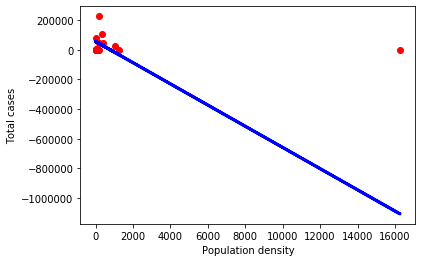

In [48]:
linearRegression(df_regression_friendly['Population density'], df_regression_friendly['Total cases'],'Population density','Total cases')

At a first glance, no correlation seems to be exist. But before draw this conclusion, let's try to remove the data that seems to be an outlier and then try to compute the regression again. Basing on the last graph, we consider outlier the value greater than 40000 total cases, because, respect to the other countries, their value is very far and could be particular cases of the virus spread. As done before, we compute the linear regression between the population density and the total number of cases first, and then, the ratio cases-population

Coefficients: 
 [-0.43300981]
Mean squared error: 33455669.68
Coefficient of determination: -0.50


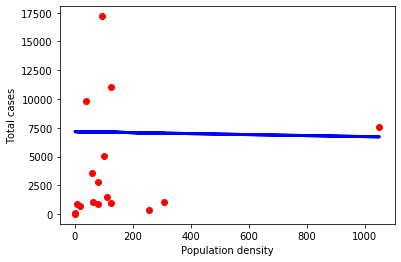

In [49]:
df_regression_friendly_WO=df_regression_friendly[df_regression_friendly['Total cases']<40000].copy()

linearRegression(df_regression_friendly_WO['Population density'], df_regression_friendly_WO['Total cases'],'Population density','Total cases')

Now, let's try to compute the same analysis but scaling the total number of cases with the population of each country. In this way, it is possible to see the correlation between the population density and the total number of cases in ratio with the population, that should be a more correct way to compare the data.

Coefficients: 
 [8.75896272e-08]
Mean squared error: 0.00
Coefficient of determination: 0.00


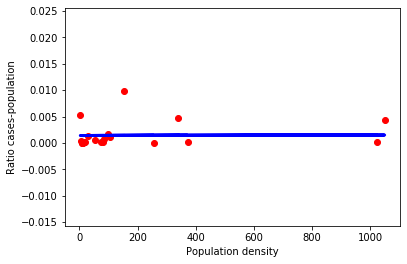

In [50]:
linearRegression(df_regression_friendly['Population density'], df_regression_friendly['Ratio cases-population'],'Population density','Ratio cases-population')

In [51]:
df_regression_friendly.corr()

,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Lockdown state,Ratio cases-population
Total cases,1.000000,0.927471,0.212382,-0.035083,0.177205,0.232594,NaN,0.177205
Total deaths,0.927471,1.000000,0.159277,-0.031307,0.204009,0.397629,NaN,0.204009
Population,0.212382,0.159277,1.000000,-0.024254,-0.093923,-0.054543,NaN,-0.093923
Population density,-0.035083,-0.031307,-0.024254,1.000000,0.057818,0.042576,NaN,0.057818
Total cases per million of inhabitants,0.177205,0.204009,-0.093923,0.057818,1.000000,0.763091,NaN,1.000000
Total deaths per million of inhabitants,0.232594,0.397629,-0.054543,0.042576,0.763091,1.000000,NaN,0.763091
Lockdown state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratio cases-population,0.177205,0.204009,-0.093923,0.057818,1.000000,0.763091,NaN,1.000000


The statistic descriptions, the graph and the correlation table suggest that there isn't any correlation between the total number of cases and the population density. The table shows that there is a strong correlation only between the total number of cases and the total number of deaths.

Even without the outliers, no correlation appears to be present between the population density and the total number of cases.
As a last trial, try to consider only the countries where the virus has a significant spread. We consider only the countries that had a least more than 200 confirmed cases in a day and a growth rate in the week after the first 200 new cases day of more than a certain value.

Firstly, let's filter the countries that have passed the 200 new confirmed cases in a day.

In [52]:
country_list=[]
beg_list=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                country_list.append(country)
                beg_list.append((country,df_matrix_new_cases.index[i]))
                break

                
df_regression_friendly_200 = df_regression_friendly[df_regression_friendly['Country'].isin(country_list)].copy()   
df_regression_friendly_200.head()


,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197
5,2020-05-20,Argentina,8796,393,45195774,14.4,194.619966,8.695503,2020-03-20,2,0.000195
6,2020-05-20,Armenia,5041,64,2963243,99.9,1701.176718,21.597959,2020-03-24,2,0.001701
7,2020-05-20,Austria,16257,632,9006398,97.7,1805.050143,70.172337,2020-03-16,2,0.001805
8,2020-05-20,Azerbaijan,3518,41,10139177,91.9,346.970962,4.043721,2020-03-02,2,0.000347


Now, let's add in the dataset a column where storing the growth rate in the week after the first days where the new confirmed cases have passed the value of 200.

In [53]:
growth_percentage=[]
country_list=[]
for i in range(len(beg_list)):
    c=df_all_data[df_all_data['Country']==beg_list[i][0]]
    d=c[c['Date']==(beg_list[i][1]+ timedelta(days=7))]
    e=c[c['Date']==beg_list[i][1]]

    try:        
        growth_percentage.append(((d['Total cases'].iloc[0]-e['Total cases'].iloc[0])/d['Total cases'].iloc[0])*100)
        country_list.append(beg_list[i][0])
    except:
        print()

df_regression_friendly_200_growth = df_regression_friendly[df_regression_friendly['Country'].isin(country_list)].copy() 

g2=[]
c2=[]

for i in range(len(growth_percentage)):
            if(country_list[i] in df_regression_friendly_200_growth['Country'].tolist()):
                g2.append(growth_percentage[i])
                c2.append(country_list[i])
                
df_regression_friendly_200_growth['Growth rate']=g2
df_regression_friendly_200_growth.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population,Growth rate
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197,39.068201
5,2020-05-20,Argentina,8796,393,45195774,14.4,194.619966,8.695503,2020-03-20,2,0.000195,19.301628
7,2020-05-20,Austria,16257,632,9006398,97.7,1805.050143,70.172337,2020-03-16,2,0.001805,76.315065
9,2020-05-20,Bahrain,7532,12,1701575,1050.5,4426.487225,7.052290,2020-02-25,2,0.004426,28.631358
10,2020-05-20,Bangladesh,25121,370,164689383,1023.4,152.535637,2.246654,2020-03-19,2,0.000153,70.076878


Let's plot a distribution of the growth rate

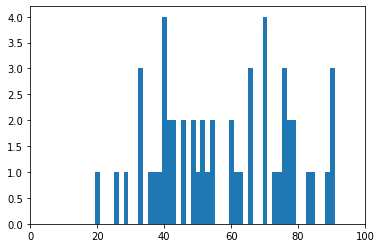

count    53.000000
mean     57.519100
std      19.029279
min      19.301628
25%      42.035398
50%      54.838710
75%      74.606152
max      90.920321
Name: Growth rate, dtype: float64

In [54]:
#plot population density
plt.hist(df_regression_friendly_200_growth['Growth rate'], bins=50) 
plt.xlim(0, 100)
plt.show()
df_regression_friendly_200_growth['Growth rate'].describe()

Now, consider only the countries where the growth rate is in the upper 50 percentile, that is with a value greater than 54.

In [55]:
df_regression_friendly_200_growth_greater = df_regression_friendly_200_growth[df_regression_friendly_200_growth['Growth rate'] < 54].copy()

Let's now compute the linear regression between the population density and the total cases considering only these "most impacted" countries.

Coefficients: 
 [-7.89162299]
Mean squared error: 65849025.57
Coefficient of determination: -2.18


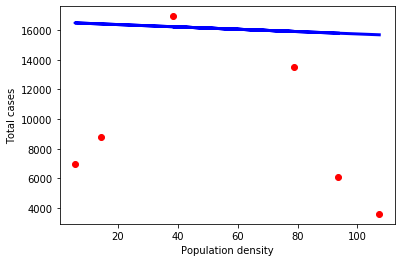

In [56]:
linearRegression(df_regression_friendly_200_growth_greater['Population density'], df_regression_friendly_200_growth_greater['Total cases'],'Population density','Total cases')

Coefficients: 
 [2.68074359e-06]
Mean squared error: 0.00
Coefficient of determination: -9.20


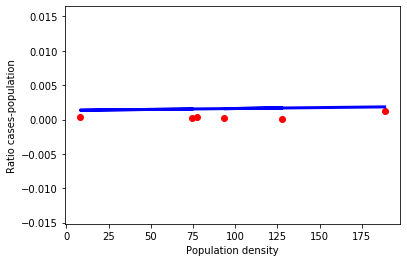

In [57]:
linearRegression(df_regression_friendly_200_growth_greater['Population density'], df_regression_friendly_200_growth_greater['Ratio cases-population'],'Population density','Ratio cases-population')

In [58]:
df_regression_friendly_200_growth_greater.corr()

,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Lockdown state,Ratio cases-population,Growth rate
Total cases,1.000000,0.355747,0.275021,-0.076441,0.235377,-0.237963,NaN,0.235377,0.304090
Total deaths,0.355747,1.000000,0.688497,-0.066233,-0.348427,-0.079880,NaN,-0.348427,0.263931
Population,0.275021,0.688497,1.000000,0.011284,-0.344808,-0.375360,NaN,-0.344808,0.278679
Population density,-0.076441,-0.066233,0.011284,1.000000,0.223478,-0.013877,NaN,0.223478,-0.136797
Total cases per million of inhabitants,0.235377,-0.348427,-0.344808,0.223478,1.000000,0.331432,NaN,1.000000,0.020684
Total deaths per million of inhabitants,-0.237963,-0.079880,-0.375360,-0.013877,0.331432,1.000000,NaN,0.331432,0.104193
Lockdown state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratio cases-population,0.235377,-0.348427,-0.344808,0.223478,1.000000,0.331432,NaN,1.000000,0.020684
Growth rate,0.304090,0.263931,0.278679,-0.136797,0.020684,0.104193,NaN,0.020684,1.000000


After this last trial, we can definetely conclude that there is no correlation between the population density and the virus spread.

# Focus on the impact of the countermeasures (lockdown)

Now, let's create a new dataset to better evaluate the impact of the lockdown in the new cases trend. The new dataset will be composed by the following column:

- country;
- peack reached: a flag to set if the peak in terms of new cases has been already reached;
- days until peak: the number of days between the first day with more than 200 new cases and the day when the peak has been reached;
- lockdown: a flag to set if the lockdown has been already put in place;
- days until lockdown: the number of days between the first day with more than 200 new cases and the day when the lockdown has been set;
- total cases: the total number of cases in the last available date;
- ratio cases-population: the ratio between the total number of cases and the population.

In [59]:
country_list,peaks,ndaysPeak,lockdown,ndaysLock = statTable(df_matrix_new_cases,df_lockdown)

In [60]:
df_stats=pd.DataFrame()

df_stats['Country']=country_list

df_stats['Peak reached']=peaks
df_stats['Days until peak']=ndaysPeak
df_stats['Lockdown']=lockdown
df_stats['Days until lockdown']=ndaysLock

df_stats.head()

,Country,Peak reached,Days until peak,Lockdown,Days until lockdown
0,Afghanistan,1,15,1,-38
1,Argentina,1,23,1,-37
2,Armenia,1,2,1,-54
3,Australia,1,1,0,59
4,Austria,1,11,1,0


In [61]:
temp = df_all_data[df_all_data['Date']=='2020-05-20'].copy()
ratio_list=[]
total_list=[]
for country in df_stats['Country']:
        temp2=temp[temp['Country']==country]
        ratio_list.append(temp2['Total cases'].iloc[0]/temp2['Population'].iloc[0])
        total_list.append(temp2['Total cases'].iloc[0])


In [62]:
df_stats['Total cases'] = total_list.copy()
df_stats['Ratio cases-population'] = ratio_list.copy()

df_stats.head()

,Country,Peak reached,Days until peak,Lockdown,Days until lockdown,Total cases,Ratio cases-population
0,Afghanistan,1,15,1,-38,7653,0.000197
1,Argentina,1,23,1,-37,8796,0.000195
2,Armenia,1,2,1,-54,5041,0.001701
3,Australia,1,1,0,59,7068,0.000277
4,Austria,1,11,1,0,16257,0.001805


Let's plot the trend of the new cases with the lockdown insertion for the top ten countries for number of new cases. We plot each country in a different plot printing the value of "days until lockdown" and "days until peak".

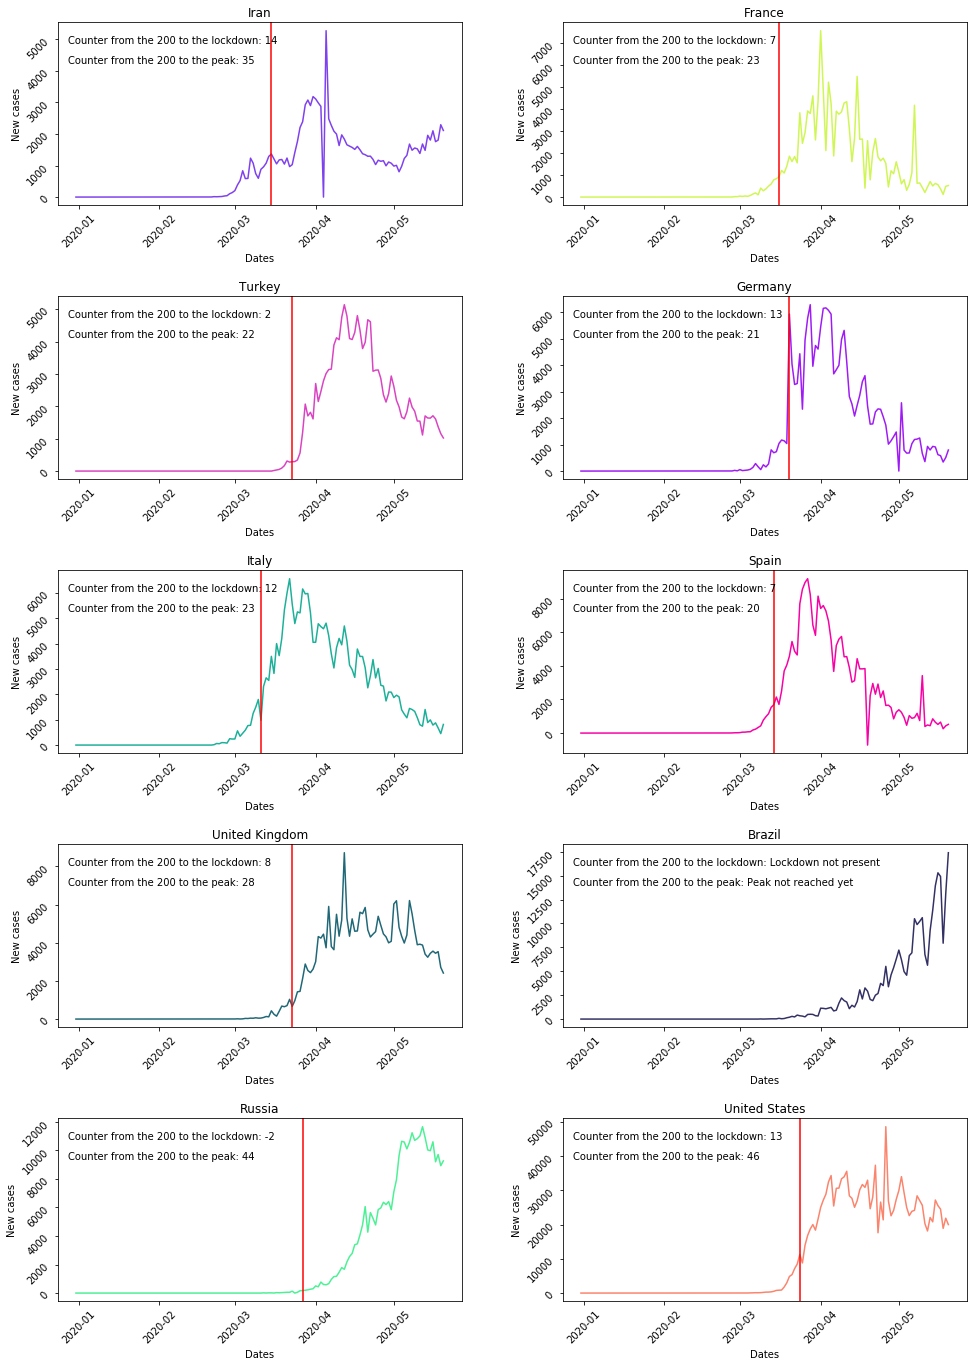

In [63]:
max_cases=df_matrix_new_cases.sum(axis = 0, skipna = True)
top_ten_new_cases_moving_average=max_cases.sort_values()[-10:].index

plotWithLockdown(top_ten_new_cases_moving_average,df_lockdown,df_matrix_new_cases,'New cases')

Let's split the dataset between countries where the lockdown has been put in place and countries where the lockdown has not been set

In [64]:
df_stats_no_lock = df_stats.loc[df_stats['Lockdown'] == 0].copy()
print("Number of countries where the lockdown has not been set: ", len(df_stats_no_lock))
df_stats_no_lock 

Number of countries where the lockdown has not been set:  8


,Country,Peak reached,Days until peak,Lockdown,Days until lockdown,Total cases,Ratio cases-population
3,Australia,1,1,0,59,7068,0.000277
8,Belarus,1,12,0,41,31508,0.003334
11,Brazil,0,60,0,60,271628,0.001278
12,Cameroon,1,37,0,46,3529,0.000133
59,Sudan,1,0,0,2,2591,0.000059
60,Sweden,1,31,0,56,30799,0.003050
62,Tajikistan,1,0,0,4,1729,0.000181
69,Zambia,1,0,0,5,772,0.000042


In [65]:
df_stats_lock = df_stats.loc[df_stats['Lockdown'] == 1].copy()
print("Number of countries where the lockdown has been set: ", len(df_stats_lock))
df_stats_lock.head()

Number of countries where the lockdown has been set:  62


,Country,Peak reached,Days until peak,Lockdown,Days until lockdown,Total cases,Ratio cases-population
0,Afghanistan,1,15,1,-38,7653,0.000197
1,Argentina,1,23,1,-37,8796,0.000195
2,Armenia,1,2,1,-54,5041,0.001701
4,Austria,1,11,1,0,16257,0.001805
5,Azerbaijan,0,0,1,-79,3518,0.000347


Now, let's try to plot the distribution of the number of days until peak of the two datasets, to better understand if there is a significative difference.

Distribution of the number of days until peak for the countries without lockdown


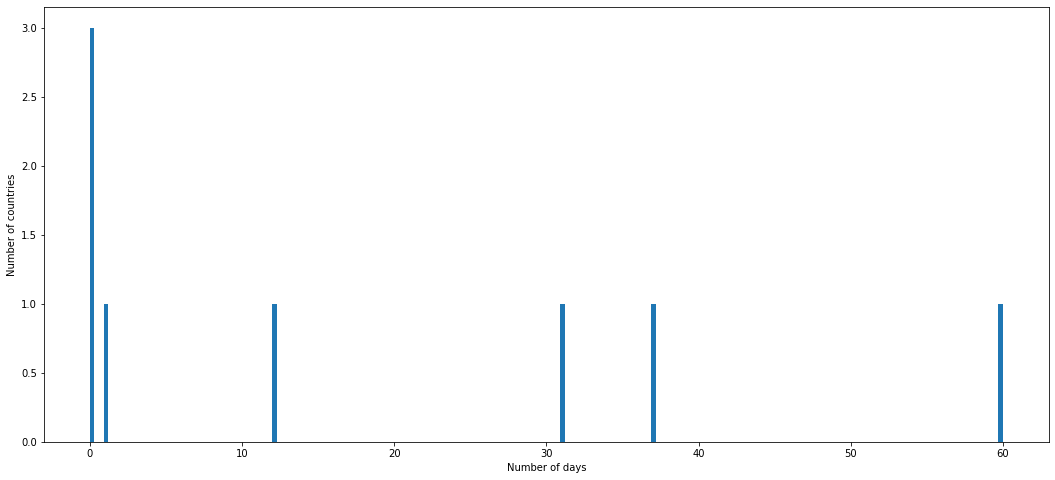

Statistic descriptions:


count     8.000000
mean     17.625000
std      22.645955
min       0.000000
25%       0.000000
50%       6.500000
75%      32.500000
max      60.000000
Name: Days until peak, dtype: float64

In [130]:
print("Distribution of the number of days until peak for the countries without lockdown")
plt.hist(df_stats_no_lock['Days until peak'], bins=200)
plt.xlabel("Number of days")
plt.ylabel("Number of countries")
plt.show()
print("Statistic descriptions:")
df_stats_no_lock['Days until peak'].describe()

Distribution of the number of days until peak for the countries with lockdown


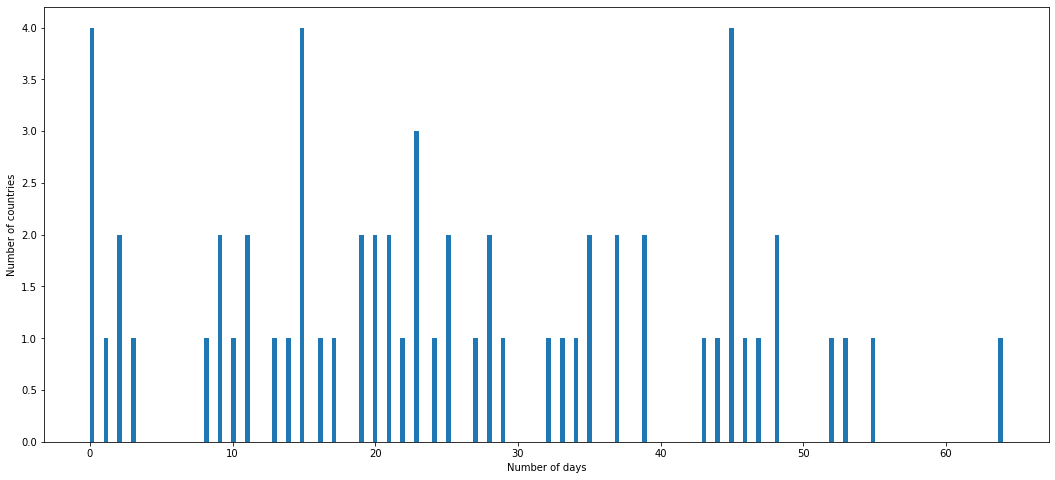

Statistic descriptions:


count    62.000000
mean     25.548387
std      16.355354
min       0.000000
25%      14.250000
50%      23.000000
75%      38.500000
max      64.000000
Name: Days until peak, dtype: float64

In [131]:
print("Distribution of the number of days until peak for the countries with lockdown")
plt.hist(df_stats_lock['Days until peak'], bins=200) 
plt.xlabel("Number of days")
plt.ylabel("Number of countries")
plt.show()
print("Statistic descriptions:")
df_stats_lock['Days until peak'].describe()

Looking at this data, it seems that the lockdown as a countermeasure don't have a significative impact. The distribution between the two datasets is very similar. Of course, we have to consider that the number of data about the countries without lockdown is small but we have similar distribution, similar mean and similar max value.

Now, let's focus on the countries where the peak is not yet reached.

In [68]:
df_stats_no_peak = df_stats.loc[df_stats['Peak reached'] == 0].copy()
print("Number of countries where the peak has not been reached: ", len(df_stats_no_peak))
df_stats_no_peak

Number of countries where the peak has not been reached:  9


,Country,Peak reached,Days until peak,Lockdown,Days until lockdown,Total cases,Ratio cases-population
5,Azerbaijan,0,0,1,-79,3518,0.000347
11,Brazil,0,60,0,60,271628,0.001278
14,Chile,0,55,1,0,49579,0.002594
20,Egypt,0,45,1,-12,13484,0.000132
27,India,0,48,1,-9,106750,0.000077
35,Kuwait,0,25,1,-40,16764,0.003925
38,Mexico,0,45,1,-22,54346,0.000422
47,Peru,0,48,1,-23,99483,0.003017
66,United Arab Emirates,0,47,1,-10,25063,0.002534


This last data is a further confirmation of what we noticed before: we have only 9 countries where the peak is not been reached. Only one of this countries is a country where the lockdown han not been set (Brazil).

Let's try to plot the data of these countries.

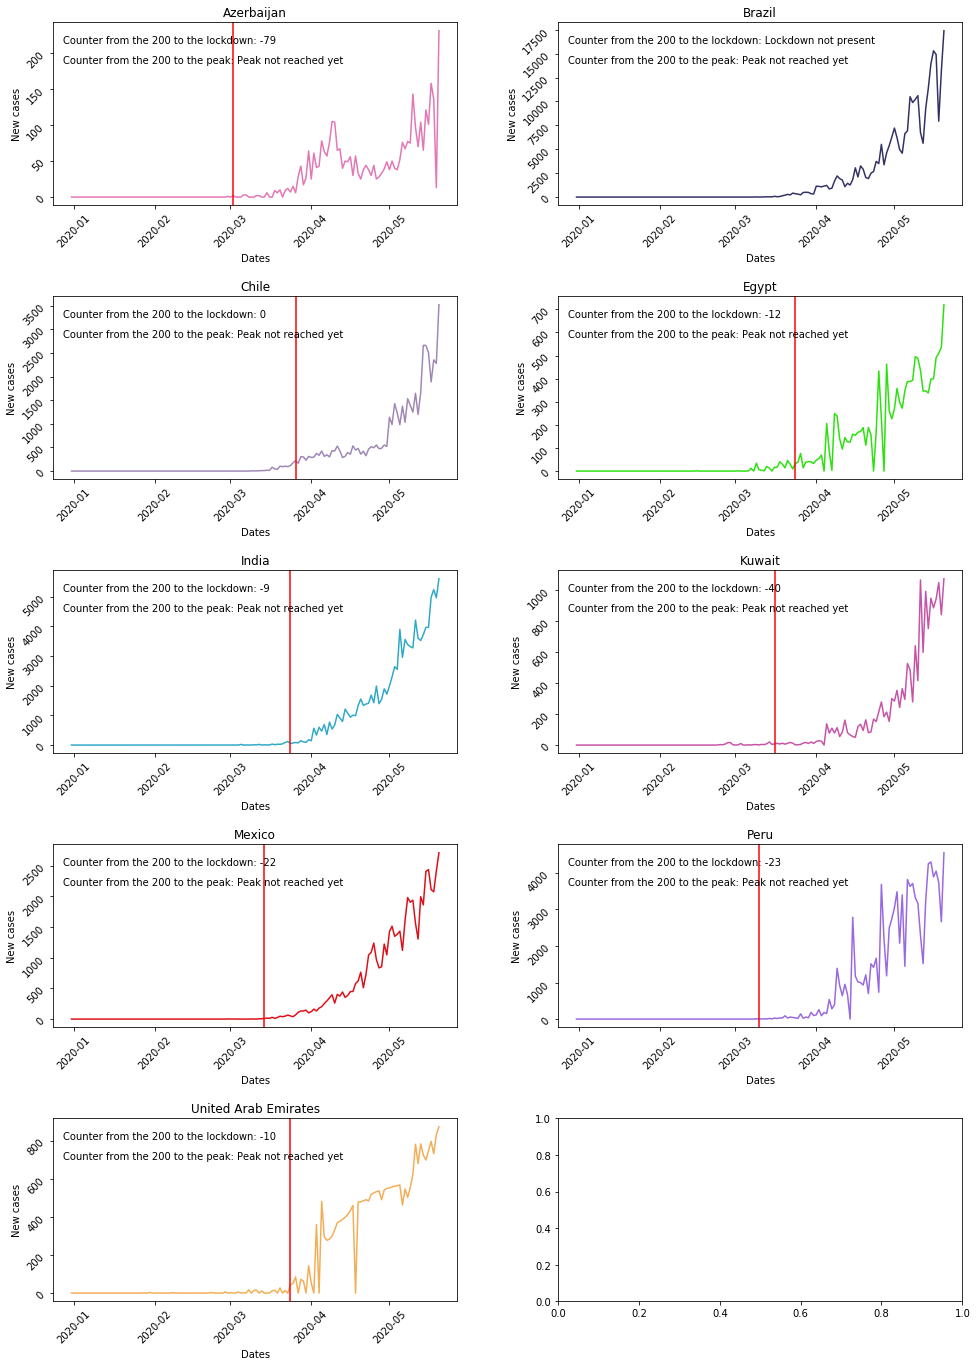

In [69]:
peak_not_reached_list = ['Azerbaijan', 'Brazil', 'Chile', 'Egypt', 'India', 'Kuwait', 'Mexico', 'Peru', 'United Arab Emirates']
plotWithLockdown(peak_not_reached_list, df_lockdown, df_matrix_new_cases, 'New cases')

Except Brazil, in all the other countries the lockdown has been set very early. In most of the cases, before reaching 200 new cases in a day, but this did not fix the problem.

Obviously, a better investigation on how the lockdown has put in place in all the countries worth to be done. But looking to our data it seems the lockdown is not a effective countermeasure. Probably, a better solution is working on the people behaviour, teaching them the importance of rispecting the distance. In Europe, an example is Sweden, where no lockdown has been put in place, let's see the graph of this country.

Sweden new cases trend


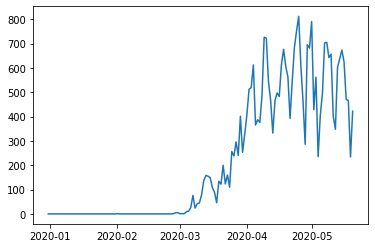

   Country  Peak reached  Days until peak  Lockdown  Days until lockdown  \
60  Sweden             1               31         0                   56   

    Total cases  Ratio cases-population  
60        30799                 0.00305  


In [70]:
print("Sweden new cases trend")
plt.plot(df_matrix_new_cases['Sweden'])
plt.show()
print(df_stats[df_stats['Country'] == 'Sweden'])

As said before, even without lockdown measure, the situation is under control and the peak has been already reached, after 31 days. The get the peak some days after other Europe countries but with a total number of cases lower (30799).

## World new cases prediction modelling

Now, let's try to predict when the new cases per day counter will reach 0 in some of the top countries for number of cases. The assumption is that the trend is decreasing because we are not able to predict when the peak will come.
Looking at the graphs of the previous section, we will take the following countries:
- Italy
- United Kingdom
- United States
- Germany
- France

In [71]:
array=[]
justNumbers=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                 array.append((country,len(df_matrix_new_cases[country][i:])))
                 justNumbers.append(len(df_matrix_new_cases[country][i:]))
                 break
print(array)
print("\nNumber of countries with more than 200 cases in a day:",len(array))

[('Afghanistan', 20), ('Argentina', 25), ('Armenia', 4), ('Australia', 60), ('Austria', 66), ('Azerbaijan', 1), ('Bahrain', 37), ('Bangladesh', 36), ('Belarus', 42), ('Belgium', 63), ('Bolivia', 18), ('Brazil', 61), ('Cameroon', 47), ('Canada', 60), ('Chile', 56), ('China', 118), ('Colombia', 43), ('Denmark', 70), ('Dominican Republic', 50), ('Ecuador', 61), ('Egypt', 46), ('Finland', 46), ('France', 73), ('Germany', 75), ('Ghana', 31), ('Honduras', 13), ('Hungary', 41), ('India', 49), ('Indonesia', 44), ('Iran', 81), ('Ireland', 58), ('Israel', 62), ('Italy', 83), ('Japan', 49), ('Kazakhstan', 37), ('Kuwait', 26), ('Luxembourg', 57), ('Malaysia', 58), ('Mexico', 46), ('Moldova', 36), ('Morocco', 46), ('Netherlands', 65), ('Nigeria', 20), ('Norway', 70), ('Oman', 37), ('Pakistan', 53), ('Panama', 42), ('Peru', 49), ('Philippines', 53), ('Poland', 53), ('Portugal', 61), ('Qatar', 70), ('Romania', 54), ('Russia', 53), ('Saudi Arabia', 57), ('Serbia', 53), ('Singapore', 41), ('South Afric

In [72]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                 if (couple[1]>=50):
                     filtered_new_cases[couple[0]]=np.array(df_matrix_new_cases[couple[0]][i:i+50])
                     break

filtered_new_cases.head()

,China,Italy,Iran,Germany,Spain,France,United States,Denmark,Norway,Qatar,...,Sweden,Chile,South Africa,Romania,Pakistan,Philippines,Poland,Russia,Serbia,Dominican Republic
0,259,250,205,284,233,410,271,252,212,238,...,256,220,218,263,211,272,249,228,202,208
1,441,238,385,163,330,286,287,160,132,0,...,238,164,243,160,118,343,224,270,82,175
2,665,240,523,55,433,372,351,128,0,58,...,296,304,17,308,99,666,193,302,0,96
3,787,561,835,237,772,497,511,23,286,17,...,240,299,93,192,414,0,256,501,159,108
4,1753,347,586,157,975,595,777,48,170,64,...,401,230,46,293,252,227,243,440,160,90


### Italy

Let's start with Italy. Firstly, let's plot the new cases time series.

Italy new cases trend


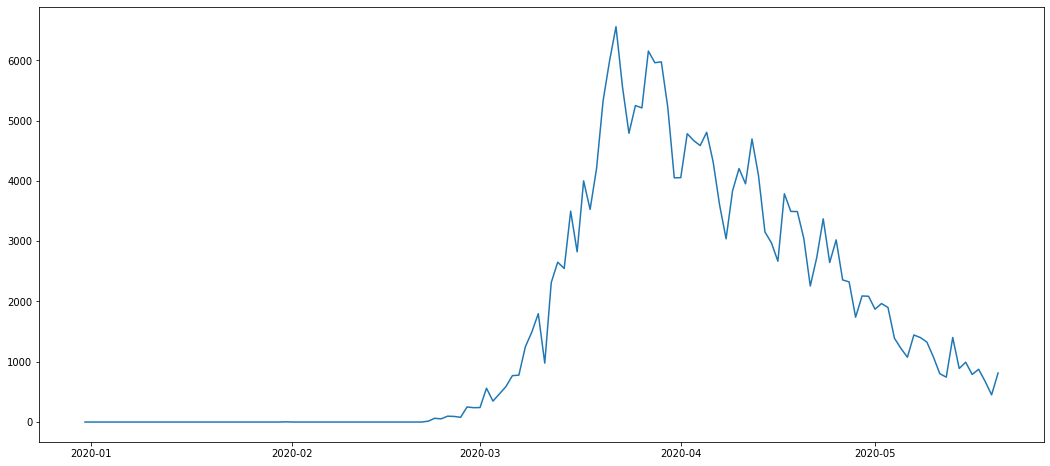

In [132]:
print("Italy new cases trend")
plt.plot(df_matrix_new_cases['Italy'])
plt.show()

Looking at this graph, it is possible to see that a model that could fit the series could be a polynomial regression model. Let's try to set a degree of two and look what happen.

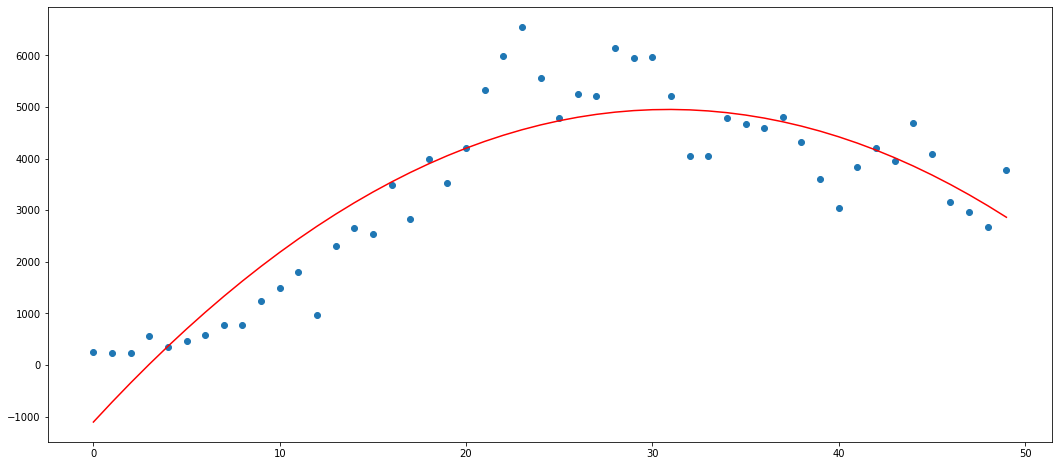

In [133]:
poly_features = PolynomialFeatures(degree=2,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()

linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

Let's try to predict some points forward respect our data

Italy


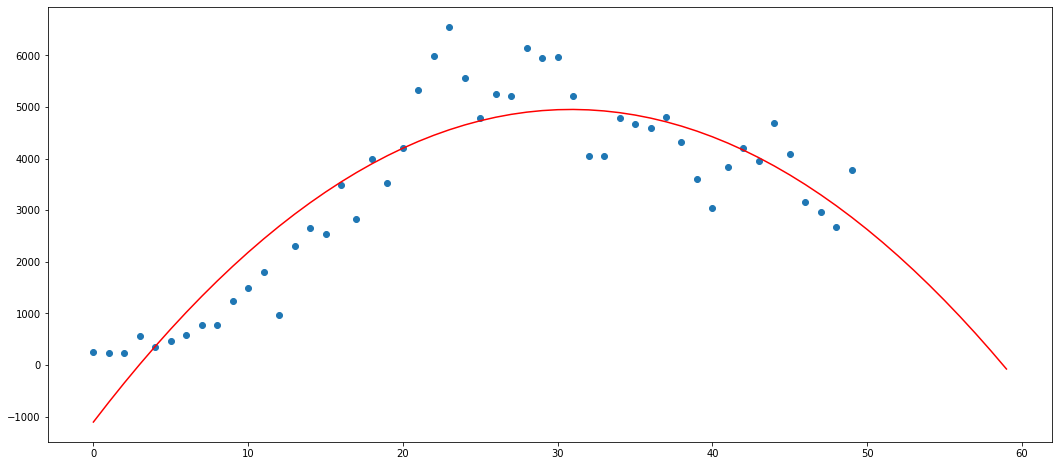

In [134]:
x_poly = poly_features.fit_transform(np.array(range(0,60)).reshape(-1, 1))

predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

Looking at this last graph, it seems our model decrease too fast.
Let's try to add a degree and see what happen.

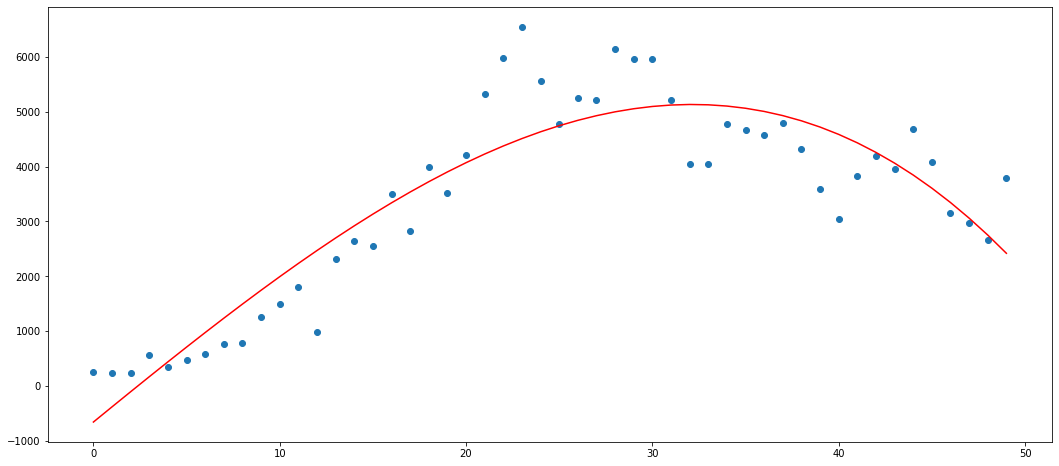

In [135]:
poly_features = PolynomialFeatures(degree=3,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()
linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

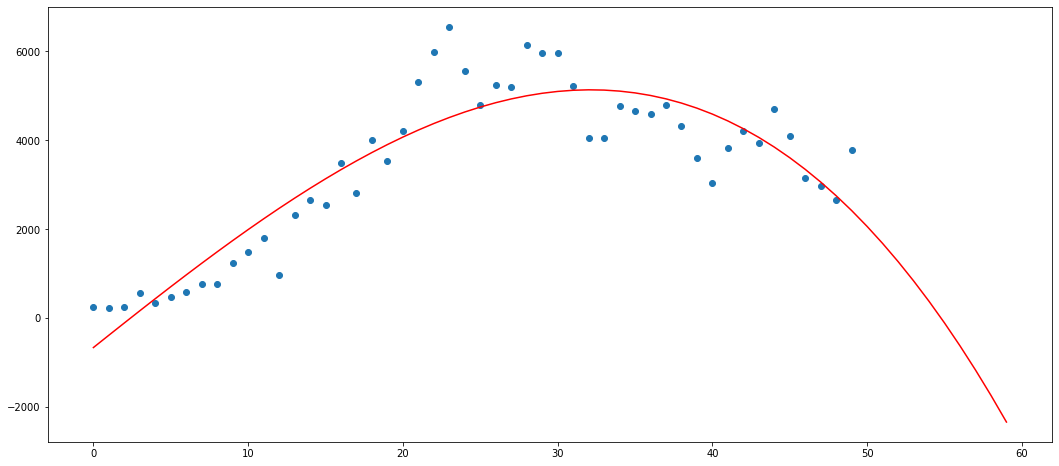

In [136]:
x_poly=poly_features.fit_transform(np.array(range(0,60)).reshape(-1, 1))

predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

Also in this case the model decrease too fast.
Focusing on the section of our data after the peak, it is possible to see that the trend is very linear. So, let's try to consider only the data after the peak and fit with a new model with degree 1.

Firstly, let's keep only the data after the first 200 cases, as done for the lockdown analysis.

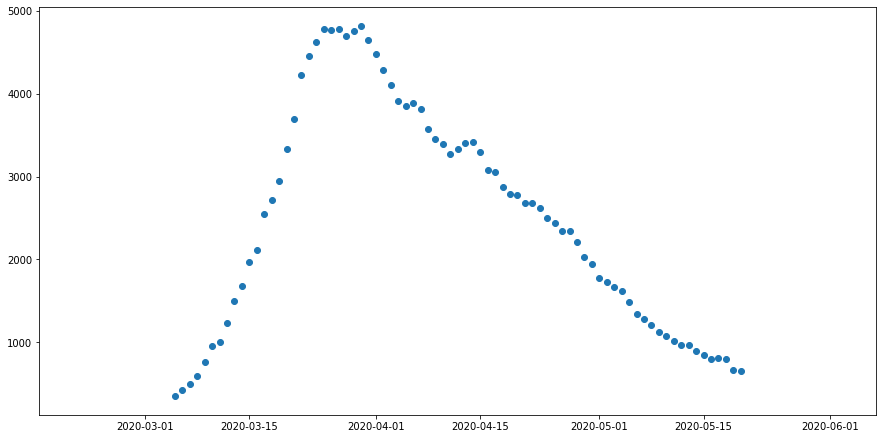

In [78]:
for i in range(0,len(df_matrix_new_cases['Italy'])):
        if(df_matrix_new_cases['Italy'][i]>200):
                 
                     italy_cases=np.array(df_matrix_new_cases['Italy'][i:])
                     italy_dates=np.array(df_matrix_new_cases.index[i:])
                     break

italy_set=pd.DataFrame()
italy_set['New cases']=italy_cases
italy_set = italy_set.set_index(italy_dates)

italy_set_am=pd.DataFrame()
window=7
italy_set_am['New cases am']=moving_mean(italy_set['New cases'],window)
italy_set_am=italy_set_am.set_index(italy_dates[window-1:])

plt.figure(figsize=(15,7.5))
plt.scatter(italy_dates[window-1:],italy_set_am['New cases am'])

Now, let's filter only the data after the peak and try to fit with the linear model, printing the R2 score of the model.

Linear Regression Model Score: 0.987747927064742


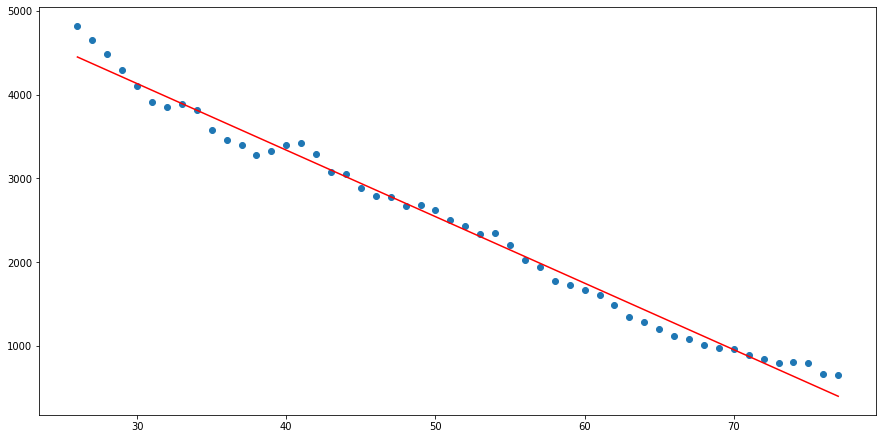

In [79]:
X, y, peak_date, linear_regr = curveAfterPeak(italy_dates, italy_set_am['New cases am'])

This last trial had a good result. The R2 score is about 99%. Let's try to predict with our model when the cases will reach 0.

0.6398700191339646


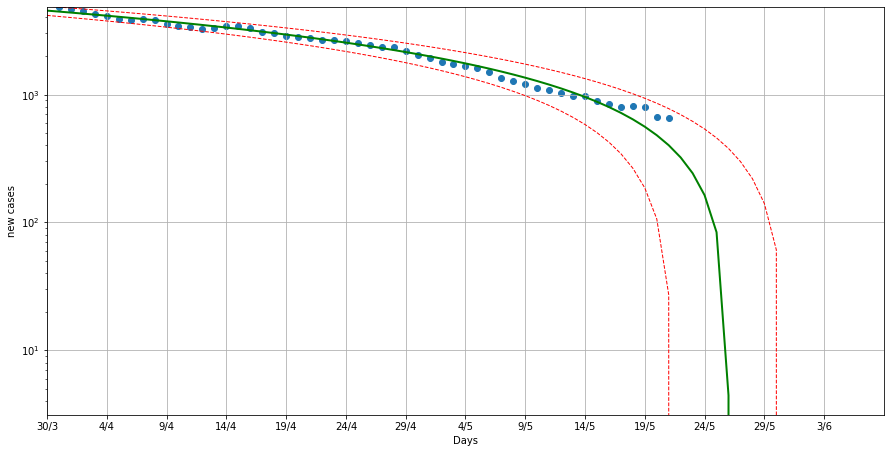

In [80]:
train_value=int(len(X)*0.70)-1
X_train=X[0:train_value]
y_train=y[0:train_value]
y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,italy_set_am.index, linear_regr,y_test,70)

Looking at this last graph, our model suggest that 0 new cases will be reached around the 27th of May, with a tollerance of about +/- 5 days.

Now, let's execute the same analysis on the next country: United Kingdom.

### United Kingdom

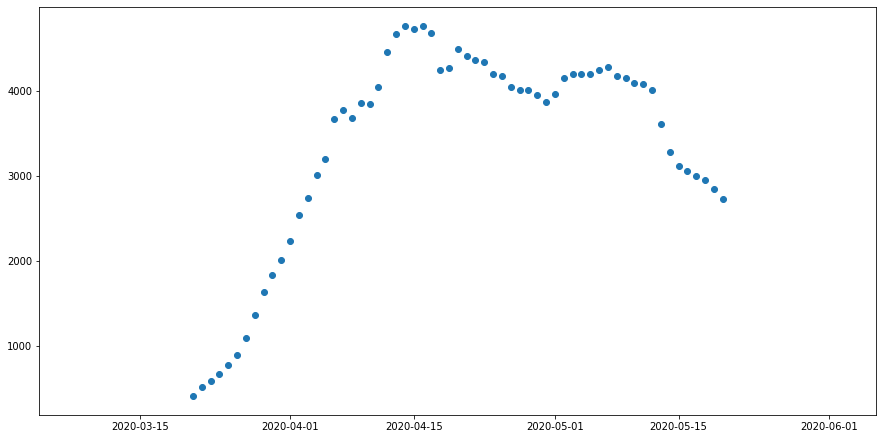

In [81]:
for i in range(0,len(df_matrix_new_cases['United Kingdom'])):
        if(df_matrix_new_cases['United Kingdom'][i]>200):
                 
                     uk_cases=np.array(df_matrix_new_cases['United Kingdom'][i:])
                     uk_dates=np.array(df_matrix_new_cases.index[i:])
                     break

uk_set=pd.DataFrame()
uk_set['New cases'] = uk_cases
uk_set = uk_set.set_index(uk_dates)

uk_set_am=pd.DataFrame()
window=7
uk_set_am['New cases am']=moving_mean(uk_set['New cases'],window)
uk_set_am=uk_set_am.set_index(uk_dates[window-1:])
plt.figure(figsize=(15,7.5))
plt.scatter(uk_dates[window-1:],uk_set_am['New cases am'])

Now, let's filter only the data after the peak and try to fit with the linear model, printing the R2 score of the model.

Linear Regression Model Score: 0.6755763348213706


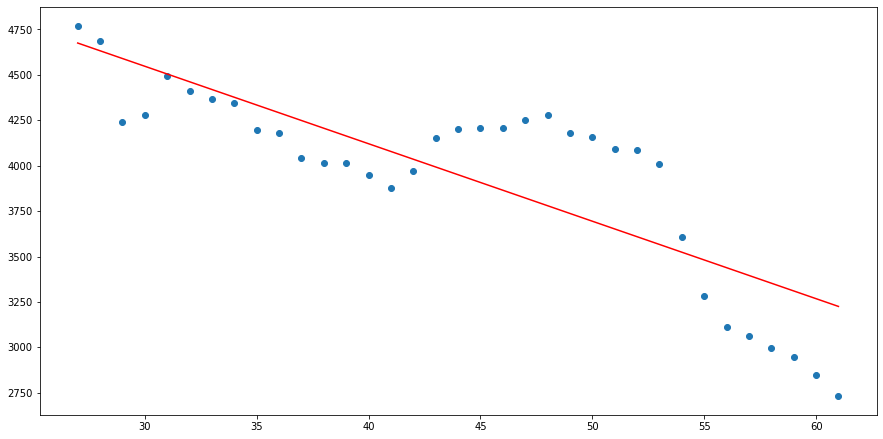

In [82]:
X, y, peak_date, linear_regr = curveAfterPeak(uk_dates, uk_set_am['New cases am'])

For this country the result is not good as for Italy. The R2 score is about 68%. Dispite this, the trend seems to be linear. Let's try to predict with our model when the cases will reach 0.

0.43513939337961116


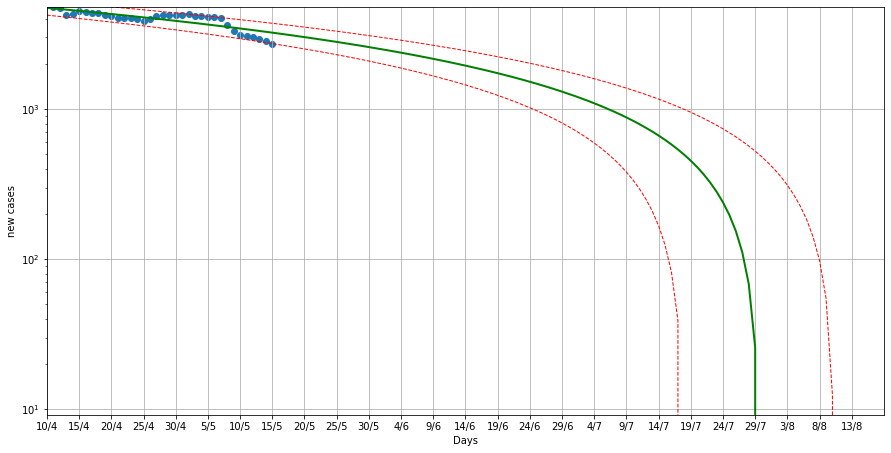

In [83]:
train_value=int(len(X)*0.70)-1
X_train=X[0:train_value]
y_train=y[0:train_value]
y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date, uk_set.index, linear_regr,y_test,130)

Looking at this last graph, our model suggest that 0 new cases will be reached around the 29th of July, with a tollerance of about +/- 12 days.

### United States

Now, let's execute the same analysis on the next country: United States.

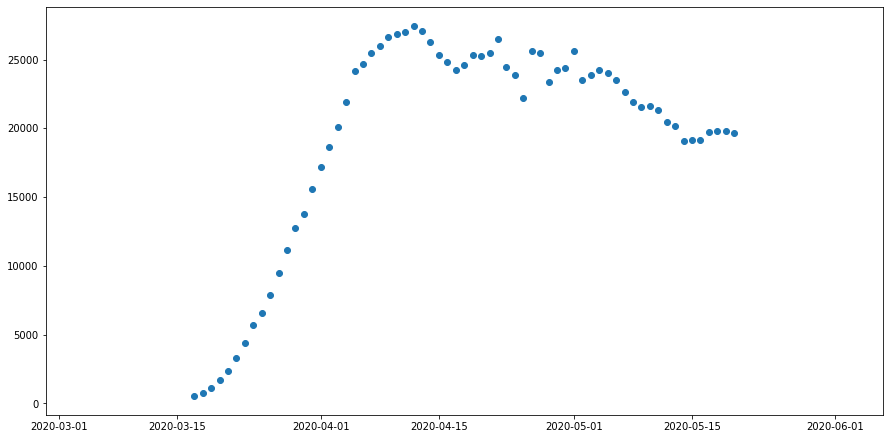

In [84]:
for i in range(0,len(df_matrix_new_cases['United States'])):
        if(df_matrix_new_cases['United States'][i]>200):
                 
                     us_cases=np.array(df_matrix_new_cases['United States'][i:])
                     us_dates=np.array(df_matrix_new_cases.index[i:])
                     break

us_set=pd.DataFrame()
us_set['New cases']=us_cases
us_set = us_set.set_index(us_dates)

us_set_am=pd.DataFrame()
window=7
us_set_am['New cases am']=moving_mean(us_set['New cases'],window)
us_set_am=us_set_am.set_index(us_dates[window-1:])
plt.figure(figsize=(15,7.5))
plt.scatter(us_dates[window-1:],us_set_am['New cases am'])

Now, let's filter only the data after the peak and try to fit with the linear model, printing the R2 score of the model.

Linear Regression Model Score: 0.8154799818365772


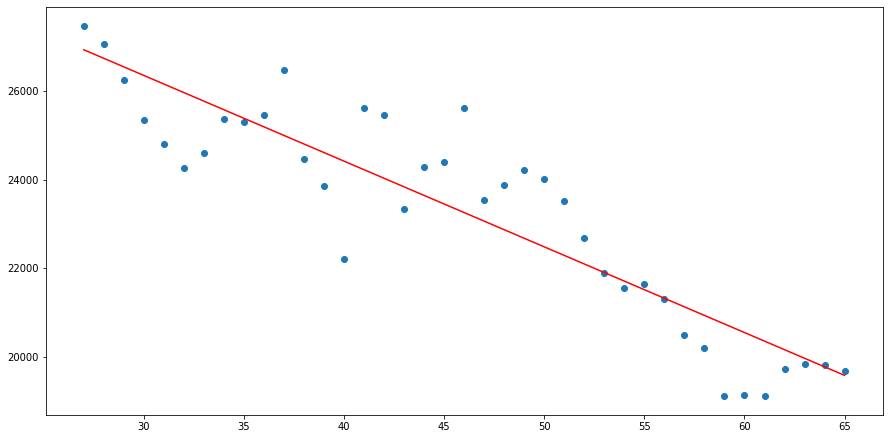

In [85]:
X, y, peak_date, linear_regr = curveAfterPeak(us_dates, us_set_am['New cases am'])

The R2 score is not so bad (82%). Let's try to predict with our model when the cases will reach 0.

0.163550784275305


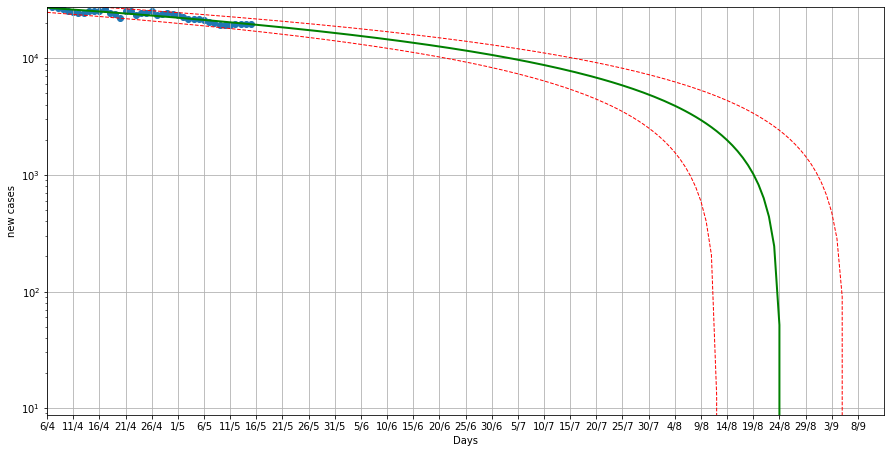

In [86]:
train_value=int(len(X)*0.70)-1
X_train=X[0:train_value]
y_train=y[0:train_value]
y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date, us_set.index, linear_regr,y_test,160)

In this case, our model says that the date when the new cases will get a value of 0 is 24th of August, with a tollerance of about +/- 12 days
Let's focus now on Germany.

### Germany

Let's apply the same procedure to Germany series.

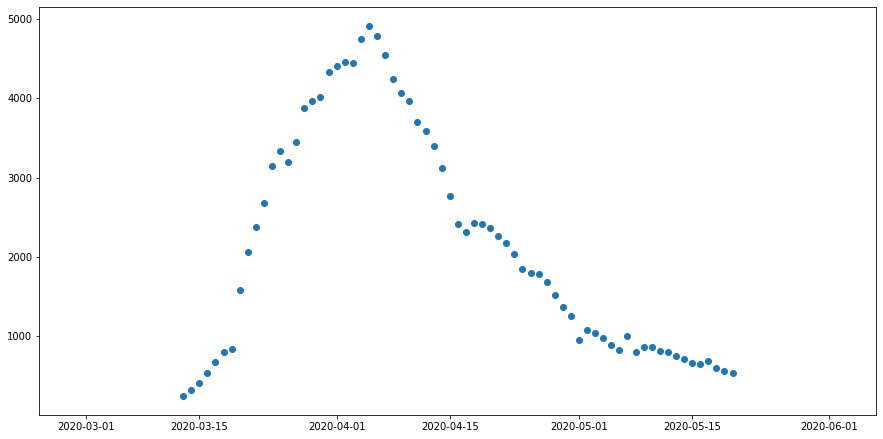

In [87]:
for i in range(0,len(df_matrix_new_cases['Germany'])):
        if(df_matrix_new_cases['Germany'][i]>200):
                 
                     germany_cases=np.array(df_matrix_new_cases['Germany'][i:])
                     germany_dates=np.array(df_matrix_new_cases.index[i:])
                     break

germany_set=pd.DataFrame()
germany_set['New cases']=germany_cases
germany_set = germany_set.set_index(germany_dates)

germany_set_am=pd.DataFrame()
window=7
germany_set_am['New cases am']=moving_mean(germany_set['New cases'],window)
germany_set_am=germany_set_am.set_index(germany_dates[window-1:])
plt.figure(figsize=(15,7.5))
plt.scatter(germany_dates[window-1:],germany_set_am['New cases am'])

Now, let's filter only the data after the peak and try to fit with the linear model, printing the R2 score of the model.

Linear Regression Model Score: 0.8914748510179387


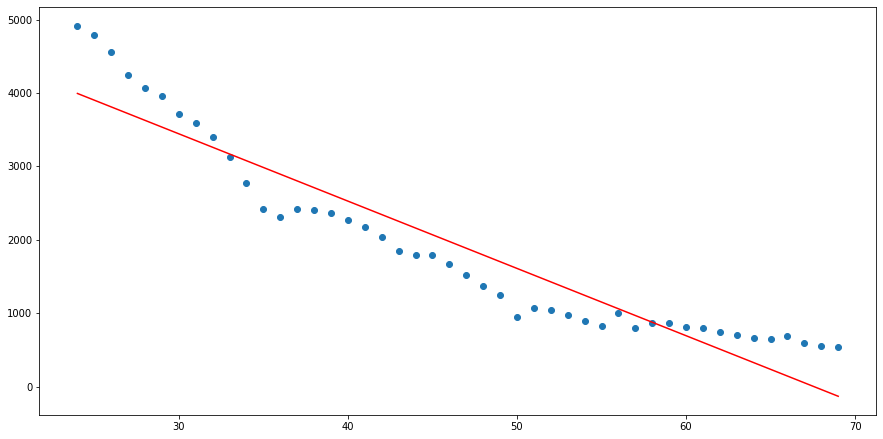

In [88]:
X, y, peak_date, linear_regr = curveAfterPeak(germany_dates, germany_set_am['New cases am'])

The R2 score is about 89%. Looking at this last graph, the trend seems to have an inflection in the last 20 days. We can try to make the prediction about the 0 new cases day but for sure it will be not correct, also because the model is trained with the first part of the dataset.

-5.560587034449621


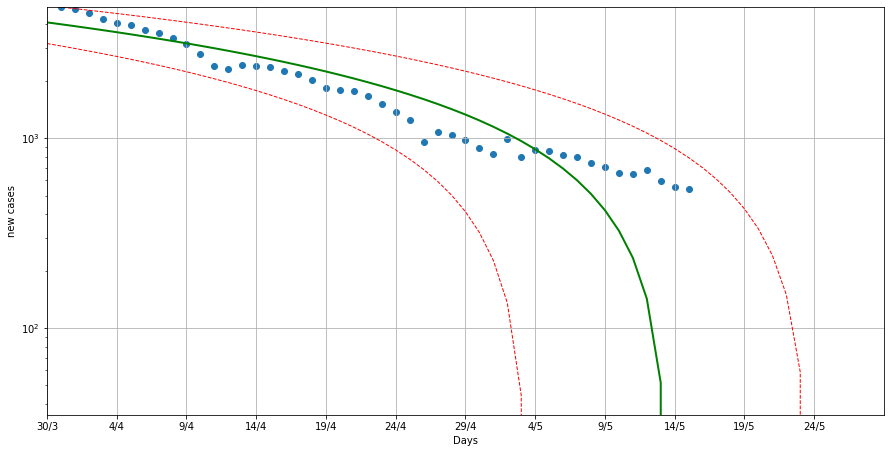

In [89]:
train_value=int(len(X)*0.70)-1
X_train=X[0:train_value]
y_train=y[0:train_value]
y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date, germany_set.index, linear_regr,y_test,60)

### France

Let's now focus on France.

In [90]:
for i in range(0,len(df_matrix_new_cases['France'])):
        if(df_matrix_new_cases['France'][i]>200):
                 
                     france_cases=np.array(df_matrix_new_cases['France'][i:])
                     france_dates=np.array(df_matrix_new_cases.index[i:])
                     break

france_set=pd.DataFrame()
france_set['New cases']=france_cases
france_set = france_set.set_index(france_dates)

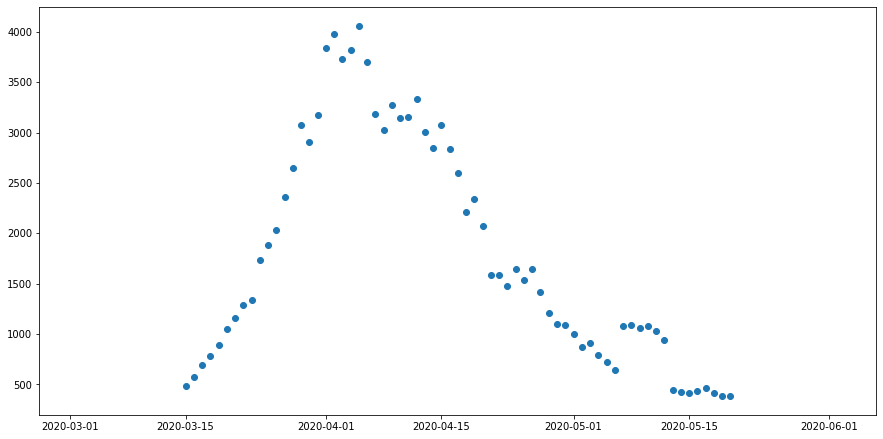

In [91]:
france_set_am=pd.DataFrame()
window=7
france_set_am['New cases am']=moving_mean(france_set['New cases'],window)
france_set_am=france_set_am.set_index(france_dates[window-1:])
plt.figure(figsize=(15,7.5))
plt.scatter(france_dates[window-1:],france_set_am['New cases am'])

Now, let's filter only the data after the peak and try to fit with the linear model, printing the R2 score of the model.

Linear Regression Model Score: 0.9018157072918186


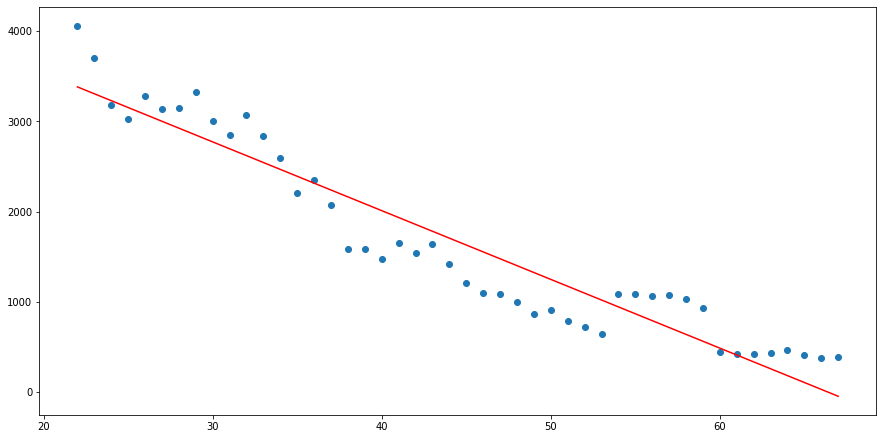

In [92]:
X, y, peak_date, linear_regr = curveAfterPeak(france_dates, france_set_am['New cases am'])

The R2 score is about 90%. Let's try to make the prediction about the 0 new cases day.

0.36872799513482146


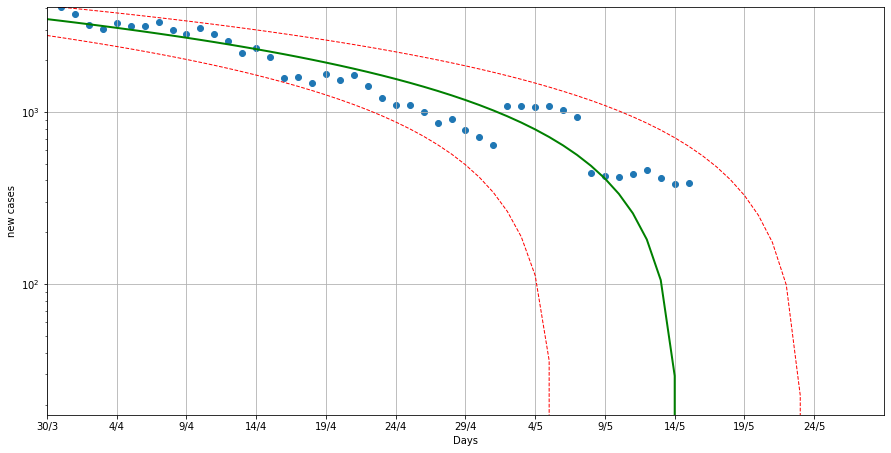

In [93]:
train_value=int(len(X)*0.70)-1
X_train=X[0:train_value]
y_train=y[0:train_value]
y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date, france_set.index, linear_regr,y_test,60)

Has noticed in Germany, the trend in the last days has an inflection so the prediction is not so accurate.

What we can conclude in this section is that where the trend is linear we can apply a linear regression model thinking the result will be correct, but, if there is an inflection in the last part of the data, the prediction will lead to optimistic evaluation in terms of 0 new cases day reached.

## PREDICTION WITH ARIMA MODEL

Now, we will try to forecast the cases series of Italy and Sweden using Arima model. Since now, Sweden is the only conuntry that has not yet introduced lockdown counter measure in Europe. We want to try to predict how the new cases number will be in the next days and compare it with Italy.  

Starting from Sweden, let's plot the series.

### Sweden

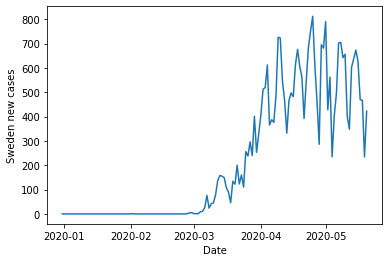

In [94]:
country_series='Sweden'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

Now, let's try to decompose the series to better understanding trend and seasonality.

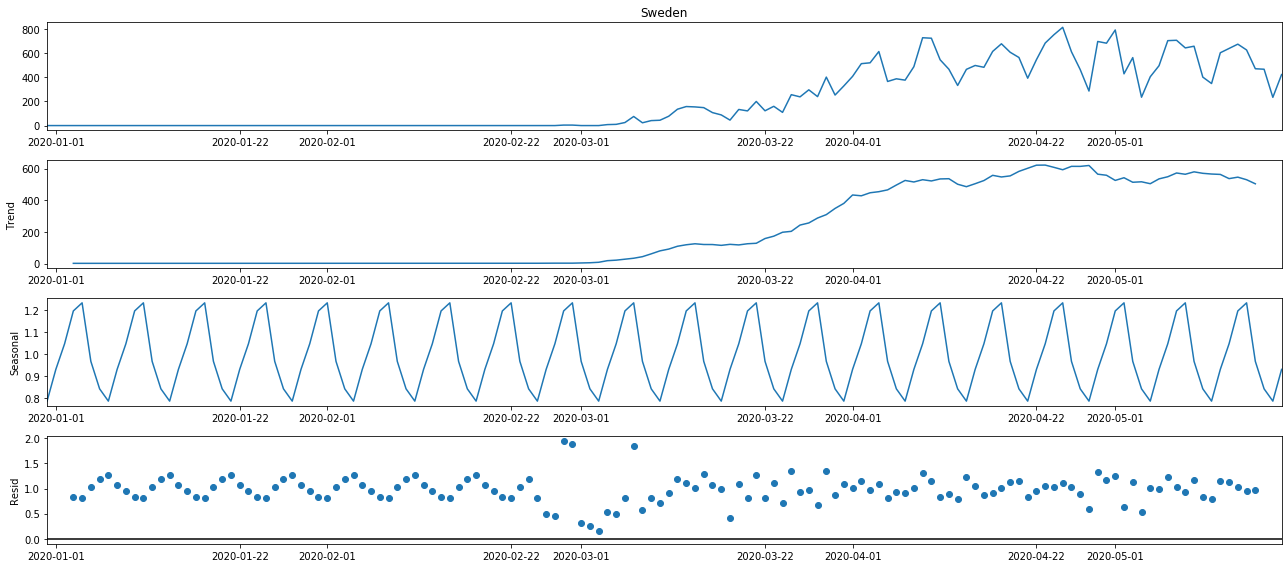

In [95]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

Sure there is a trend a little seasonality. Let's plot the autocorrelation and partial autocorrelation diagram for better understandig the seasonality.

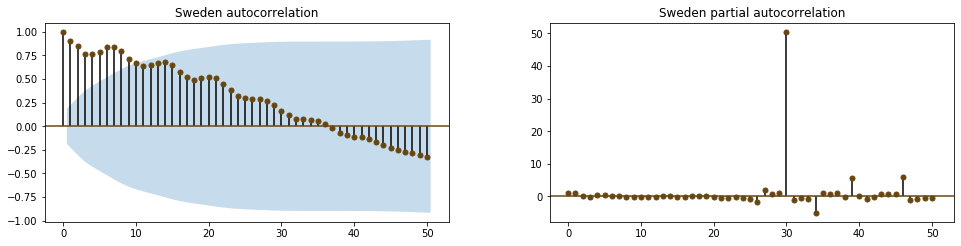

In [96]:
autocorrelationPlot('Sweden',df_matrix_new_cases,50)

Also in these last grapsh it is possible to see the trend and the seasonality is very small.
As a final test, let's compute the Dickey-Fuller test to test the stationarity.

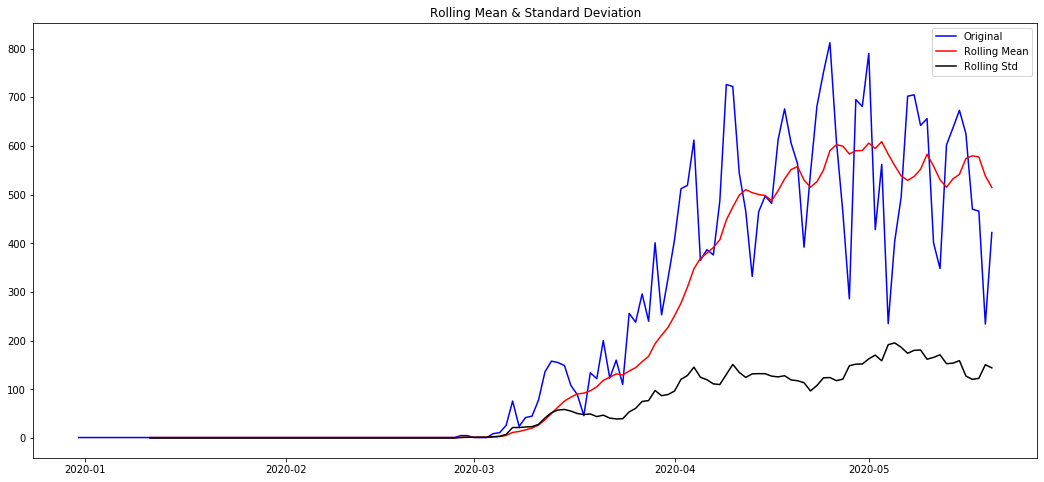

Results of Dickey-Fuller Test:


Test Statistic                  -0.560198
p-value                          0.879725
#Lags Used                      13.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

In [97]:
dftest, dfoutput = test_stationarity(df_series)
dfoutput

The test is a further confirmation of what he have seen before: the series is not stationary. The p-value is very high and also the test statistic value is upper than the critical values.

Now, let's use the auto-arima function to detect which could be the better parameters to use when performing the arima model.

In [98]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1578.523, BIC=1592.822, Fit time=0.982 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1656.803, BIC=1662.523, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1634.380, BIC=1645.819, Fit time=0.329 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1586.625, BIC=1598.064, Fit time=0.603 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1576.887, BIC=1594.045, Fit time=1.166 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=1628.100, BIC=1642.399, Fit time=0.761 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1580.860, BIC=1600.879, Fit time=3.802 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1650.128, BIC=1661.567, Fit time=0.240 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1560.669, BIC=1583.548, Fit time=3.681 seconds
Fit ARIMA: order=(0, 1, 1) s

The best Akaike Information Critera value (AIC) it that with value (3, 1, 2). Now, let's try to train the model with the data until the 10th of May and then use the remaining data to test the model.

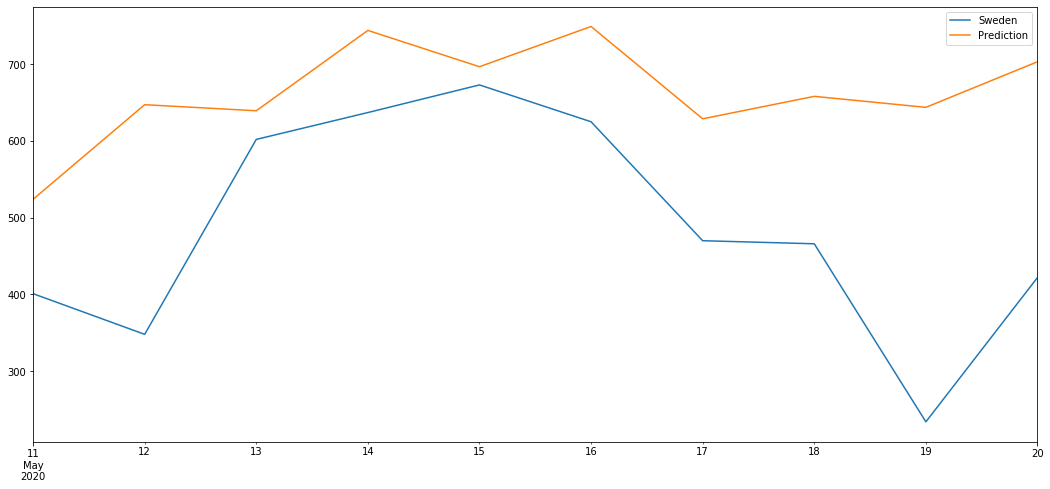

In [99]:
train = df_series.loc['2020-03-01':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

This last graph shows the prediction value. It doesn't seems to be a good result. Let's plot the prediction on the original data.

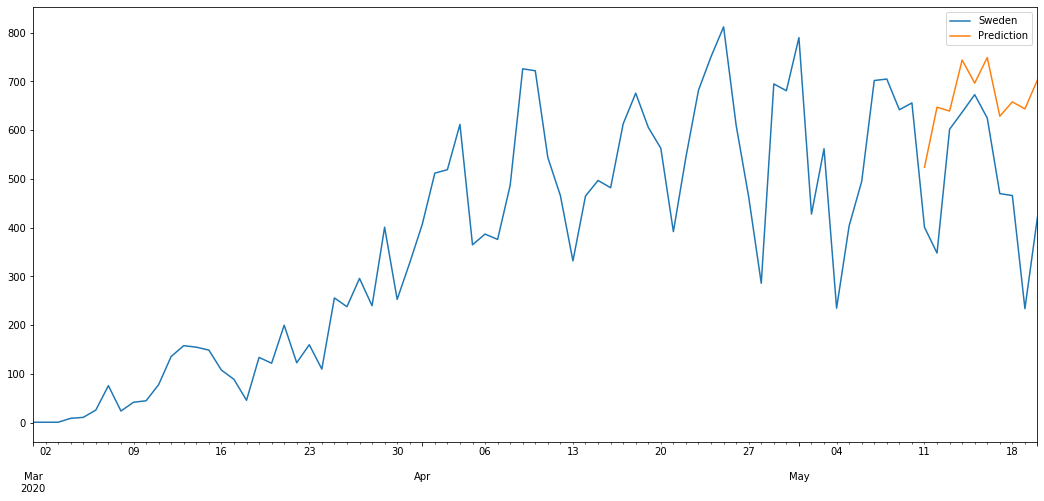

In [100]:
pd.concat([df_series.loc['2020-03-01':'2020-05-25'],future_forecast],axis=1).plot()

The prediction seems to be quite different from the real data.

Now, let's focus on Italy.

### Italy

We will use the same procedure has done before.

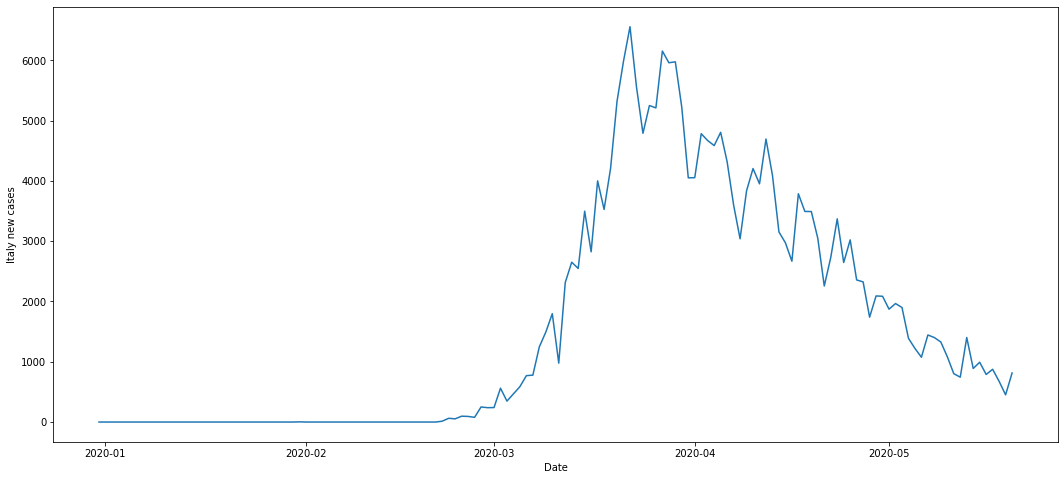

In [101]:
country_series='Italy'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

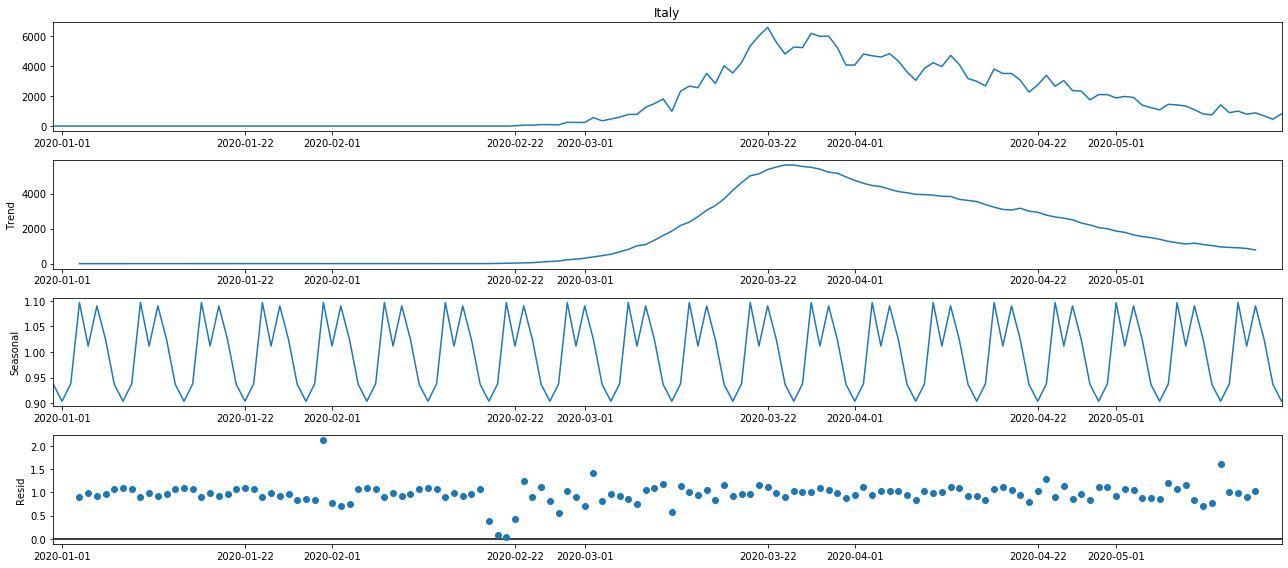

In [102]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

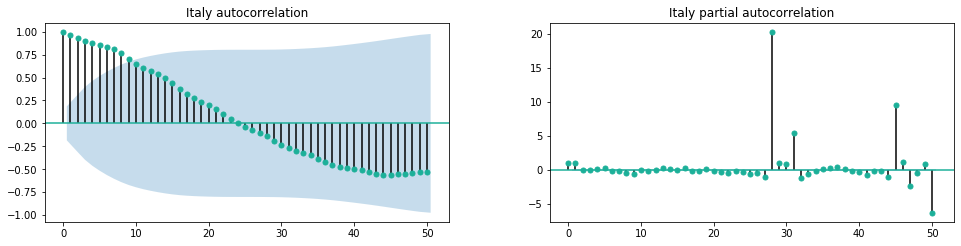

In [103]:
autocorrelationPlot('Italy',df_matrix_new_cases,50)

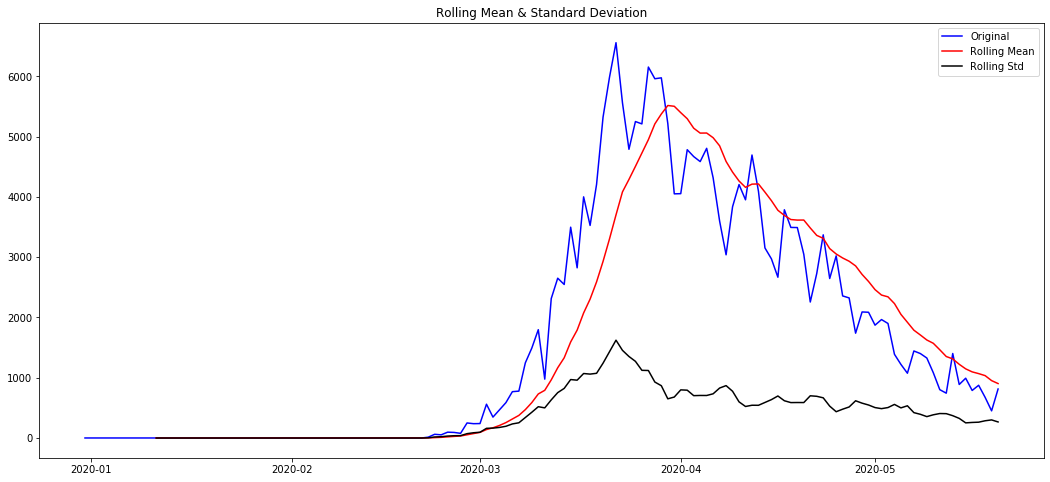

Results of Dickey-Fuller Test:


Test Statistic                  -1.782243
p-value                          0.389313
#Lags Used                      12.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [104]:
dftest, dfoutput = test_stationarity(df_series)
dfoutput

Also in this case we can conclude that the series is not stationary: there is a trend and the p-value of the Dickey-Fuller test is greater than 5%. Let's perform the auto-arima functions to detect the better parameters.

In [105]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1958.027, BIC=1972.326, Fit time=0.625 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2023.267, BIC=2028.987, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2000.794, BIC=2012.233, Fit time=0.376 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1955.343, BIC=1966.782, Fit time=0.539 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1957.177, BIC=1971.476, Fit time=0.973 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2024.164, BIC=2032.743, Fit time=0.039 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1957.082, BIC=1971.381, Fit time=2.539 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1959.384, BIC=1976.543, Fit time=2.877 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1954.026, BIC=1962.605, Fit time=0.340 seconds
Fit ARIMA: order=(0, 1, 0) s

As done for Sweden series, we now train the model with data until 10th of May and then test the model with the remaining data.

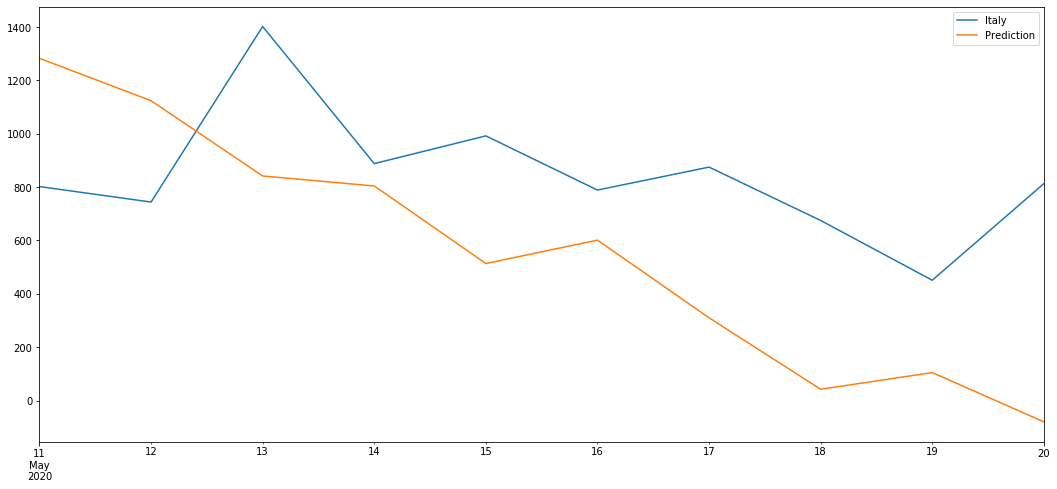

In [106]:
train = df_series.loc['2020-02-22':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

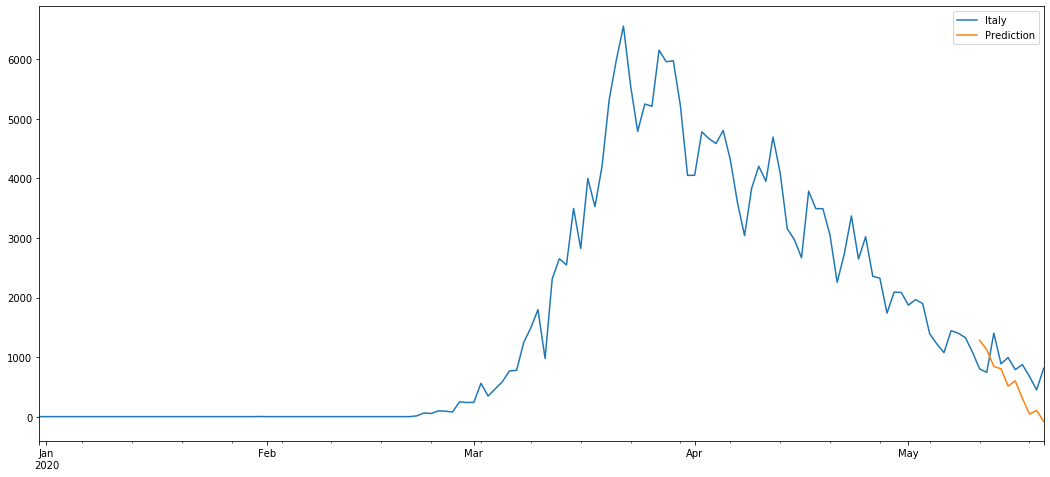

In [107]:
pd.concat([df_series,future_forecast],axis=1).plot()

Also in this case the prediction seems not to fit well the data. Seems the predicted data dcrease faster than the real data. 